# **3. Analysis of the 3D chromatin interactions among promoters in the clusters of genes: Hi-C map of contacts (*Bonev et al. 2017*)**

The following steps are included in the analysis:

1.   Define initial variables and file/folder paths
2.   Inspect the score distribution of contacts to set max_score, min_score and intervals of the distribution
3.   Calculate same chromosome ('inta-chr') and different chromosome ('inter-chr') contacts. Optimize using chunks of work
4.   Merge results obtained in the chunks of work. Calculate the non-significative contacts required to determine the frequency of significant contacts.
5.   Plot frequency of contacts in the distribution and dotplots

**1.   Define initial variables and file/folder paths**


In [ ]:
drive_folder = "/content/drive/My Drive/Miguel_TFM"

# Classes_folder
classes_folder = drive_folder + "/Part3.Gene_Interactions/"

# Matrix file path
matrix_filepath = drive_folder + "/Part3.Gene_Interactions/" + "4DNFI4OUMWZ8.hic"

# Promoters coordinates folder
promoters_mm10 = drive_folder + "/Promoters_clusters_NEW"

promoters_folder = promoters_mm10

In [ ]:
# Import packages and Drive
!pip install hic-straw

import numpy as np
import pandas as pd
import hicstraw
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import itertools
import random
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
from types import MappingProxyType
from google.colab import drive
drive.mount('/content/drive')

# Import classes: Feature, Promoter and Contact
sys.path.append(classes_folder)
from Contact import Contact
from Promoter import Promoter

  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for hic-straw: filename=hic_straw-1.3.1-cp310-cp310-linux_x86_64.whl size=1610059 sha256=923f5557f3b98e474495e7e45e6e248c636b4f54de8bb987ce5da59ba568fadf
  Stored in directory: /root/.cache/pip/wheels/23/85/e0/14f1be833ddf1da34165e04938653e00b602eb93e834497ae4
Successfully built hic-straw
Mounted at /content/drive


In [ ]:
def GetMatrixObject(matrix_filepath):

  # Obtain matrix object
  if os.path.exists(matrix_filepath):
      print("The data file exists at the specified path.")
  else:
      print("The data file does not exist at the specified path.")
  hic = hicstraw.HiCFile(matrix_filepath)
  return hic

# Get pairs of chromosome-chromosome interactions to analyze
def GetChrPairs(chromosomes):
  chr_pairs = list(itertools.combinations(chromosomes, 2))
  # Add pairs of each chromosome with itself
  for chromosome in chromosomes:
      chr_pairs.append((chromosome, chromosome))

  return chr_pairs

def LoadPromoterObjects(clusters_path):
  # Load promoter instances from bedfile
  cluster_pattern = r"_([^_]*)cluster([^_]*)_"
  cluster_names = []

  if os.path.exists(clusters_path):
      files = os.listdir(clusters_path)

      for file in files:
          cluster_match = re.search(cluster_pattern, file)
          cluster_name = cluster_match.group(0).strip('_')
          cluster_names.append(cluster_name)
          file_path = clusters_path + "/" + file
          print(file_path, cluster_name)
          Promoter.LoadFromBedfile(file_path, cluster_name)
  else:
      print("The specified directory does not exist.")

def CreateFolder(folder_path):
  # Check if the directory exists
  if not os.path.exists(folder_path):
      # Create the directory if it doesn't exist
      os.makedirs(folder_path)
      print("Folder", folder_path, "created successfully.")
  else:
      print("Folder",folder_path, "already exists.")

# This will return the bin of promoters within the interaction matrix
# for a given resolution. In case of falling in 2 bins, it retrieves the
# bin in the right
def PromotersInMatrix(matrix_resolution, chromosomes):
    matrix_resolution = int(matrix_resolution)
    matrix_indexes = {}
    for chr in chromosomes:
        matrix_indexes[chr] = {}
        chr_promoters = Promoter.RetrieveChrMembers(chr)
        for chr_promoter in chr_promoters:
            promoter_bin = (chr_promoter.end // matrix_resolution) * matrix_resolution
            if promoter_bin not in matrix_indexes[chr]:
                matrix_indexes[chr][promoter_bin] = [chr_promoter]
            else:
                matrix_indexes[chr][promoter_bin].append(chr_promoter)

    # Check matrix_indexes -> after executing
    for chr, dicti in matrix_indexes.items():
      for bin, promoters in dicti.items():
            for promoter in promoters:
              if isinstance(promoter, list):
                print('WARNING: an error occured while creating matrix indexes', promoter)

    # Checking it works with IGV
    #for bin, promoters in matrix_indexes['chr3'].items():
    #  print("{:,.0f}".format(bin), {x.identifier for x in promoters})
    return matrix_indexes

In [ ]:
# Get Hi-C Matrix
hic = GetMatrixObject(matrix_filepath)

# Get Promoter Objects
LoadPromoterObjects(promoters_folder)

# Get chromosomes names
chromosomes = [f'chr{i}' for i in range(1, 20)] + ['chrX'] + ['chrY']

# Get chromosomes length
chromosomes_length = {}
for chrom in hic.getChromosomes():
  chromosomes_length[f'chr{chrom.name}'] = int(chrom.length)

# Get chromosome pairs interactions
chr_pairs = GetChrPairs(chromosomes)

# Set Matrix Parameters
M_SCORE = 'oe'
M_BALANCING = 'KR'
M_RESOLUTION = 5000 # 5 kb. Resolutions [10000000, 5000000, 2500000, 1000000, 500000, 250000, 100000, 50000, 25000, 10000, 5000, 2000, 1000]
resolution = '5kb'

# Get indexes of promoters in matrix
matrix_indexes = PromotersInMatrix(M_RESOLUTION, chromosomes)

# Create results folder if not existing
results_folder = drive_folder + "/Part3.Gene_Interactions/" + "results_v8_3/" + f'{resolution}/'
CreateFolder(results_folder)

# Define cluster categories
clusters_comparisons = [('all', 'all'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest')]
Contact.clusters_comparisons = clusters_comparisons

# Define clusters
Contact.unique_clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']

print('\nWorking with chromosomes', chromosomes,'with chromosome lengths', chromosomes_length,'\n')
print('Working with chromosome pair interactions;', chr_pairs,'\n')
print('Working with matrix', M_SCORE, ', balancing of matrix as', M_BALANCING, 'and matrix resolution', M_RESOLUTION, resolution, '\n')
print('Working in results folder', results_folder,'\n')
print('Working with indexes of promoters in matrix', matrix_indexes,'\n')
print('Working with cluster comparisons', clusters_comparisons)

The data file exists at the specified path.
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster1B_coord.bed cluster1B
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster1A_coord.bed cluster1A
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster2_coord.bed cluster2
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster3_coord.bed cluster3
Folder /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/ already exists.

Working with chromosomes ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY'] with chromosome lengths {'chrALL': 2725521, 'chr1': 195471971, 'chr2': 182113224, 'chr3': 160039680, 'chr4': 156508116, 'chr5': 151834684, 'chr6': 149736546, 'chr7': 145441459, 'chr8': 129401213, 'chr9': 124595110, 'chr10': 130694993, 'chr11': 122

In [ ]:
# Create INTER folders
log_folder_path = results_folder + f'InterChr_contacts/' + 'logs/'
CreateFolder(results_folder + f'InterChr_contacts/')
CreateFolder(log_folder_path)

# Create INTRA folders
log_folder_path = results_folder + f'IntraChr_contacts/' + 'logs/'
CreateFolder(results_folder + f'IntraChr_contacts/')
CreateFolder(log_folder_path)

Folder /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/InterChr_contacts/ already exists.
Folder /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/InterChr_contacts/logs/ already exists.
Folder /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/IntraChr_contacts/ already exists.
Folder /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/IntraChr_contacts/logs/ already exists.


**2.   Inspect the score distribution of contacts to set max_score, min_score and intervals of the distribution**

In [ ]:
inter_chr_test = chr_pairs[10:11]
intra_chr_test = chr_pairs[-21:-20]

chr_pairs_test = inter_chr_test

Contact.reset_instances()

SearchPromotersContacts(hic, chr_pairs_test, M_SCORE, M_BALANCING, M_RESOLUTION, matrix_indexes)
score_values = [contact.score for contact in Contact.all_contacts]
print('There are', "{:,.0f}".format(len(score_values)), 'bin interactions with min and max scores:', "{:,.0f}".format(min(score_values)), '-', "{:,.0f}".format(max(score_values)))

In [ ]:
inter_threshold = [50, 100, 150, 200, 250, 300, 350]
intra_threshold = [10, 15, 20, 25, 50, 100, 150, 200, 300, 400, 500]

# Select INTER or INTRA
score_thresholds = inter_threshold

# Search contacts
subsample_percentage = 0.4

for score_threshold in score_thresholds:

    # Filter below threshold
    score_newvalues = [score for score in score_values if score < score_threshold]
    interactions_removed = len(score_values) - len(score_newvalues)
    print('Threshold =', score_threshold ,'. There has been', "{:,.0f}".format(interactions_removed), 'removed out of the initial', "{:,.0f}".format(len(score_values)))

    # Set subsample size
    subsample_size = int(len(score_newvalues) * subsample_percentage)
    subsample = random.sample(score_newvalues, subsample_size)

    # Calculate the histogram
    hist, bins = np.histogram(subsample, bins=20)

    # Calculate relative counts
    relative_counts = hist / len(subsample)

    # Plot the relative counts
    plt.bar(bins[:-1], relative_counts, width=np.diff(bins), color='skyblue', edgecolor='black')
    plt.xlabel('Score')
    plt.ylabel('Relative Counts')
    plt.title(f'Distribution of promoter bins interactions (resolution = {resolution})')
    plt.ylim(0, 0.6) # Set y-limit to 0.6
    png_path = results_folder + f'InitialDistribution_{score_threshold}maxscore.png'
    plt.savefig(png_path)
    plt.close()

**3.   Calculate same chromosome ('inta-chr') and different chromosome ('inter-chr') contacts. Optimize using chunks of work**

In [ ]:
def GetBinsScore(MAX_SCORE, MIN_SCORE, INTERVAL_SCORE):
  # Define discrete bins for score of contacts
  num_intervals = int((MAX_SCORE - MIN_SCORE) / INTERVAL_SCORE) + 1
  #bins = [0.0] + [MIN_SCORE + i * INTERVAL_SCORE for i in range(num_intervals)]
  bins = [MIN_SCORE + i * INTERVAL_SCORE for i in range(num_intervals)]

  return bins

def CreateReportDataframe(chr_pairs_divided, csv_path):
  if os.path.exists(csv_path):
    print('Report df:', csv_path, 'file already exists and will be loaded\n')
    report_df = pd.read_csv(csv_path, index_col=False)
  else:
    print('Report df:', csv_path, 'file does not exist and will be created\n')
    columns = ['Partition', 'Start chr_pair', 'End chr_pair', 'Processed']
    report_df = pd.DataFrame(columns=columns)
    i = 0
    for part in chr_pairs_divided:
      new_row = [i, part[0], part[-1], 'Not']
      i += 1
      report_df.loc[len(report_df)] = new_row
    # Save reporter_df in csv
    report_df.to_csv(csv_path, index=False)

  if 'Unnamed: 0' in report_df.columns:
    report_df.drop(columns=['Unnamed: 0'], inplace=True)

  print(report_df, '\n')
  return report_df

def BeginEmptyDataframe(maximum_score, minimum_score, score_interval, clusters_comparisons):
    # Create an empty list to store DataFrames for each category
    dfs = []

    # Create bins for the 'Score' column
    num_intervals = int((maximum_score - minimum_score) / score_interval) + 1
    bins = [minimum_score + i * score_interval for i in range(num_intervals)]

    # Iterate over each category
    for clusterA, clusterB in clusters_comparisons:
        # Create a DataFrame for the current comparison
        temp_df = pd.DataFrame(columns=['Score', 'Counts', 'Relative Counts', 'ClusterA', 'ClusterB'])
        temp_df['Score'] = bins
        temp_df['Counts'] = 0
        temp_df['Relative Counts'] = 0
        temp_df['ClusterA'] = clusterA
        temp_df['ClusterB'] = clusterB

        # Append the DataFrame for the current category to the list
        dfs.append(temp_df)

    # Concatenate all DataFrames in the list into a single DataFrame
    empty_df = pd.concat(dfs, ignore_index=True)
    if 'Unnamed: 0' in empty_df.columns:
      empty_df.drop(columns=['Unnamed: 0'], inplace=True)
    print('Make sure empty_df is correct to latter load Counts on it\n')
    print(empty_df)

    return empty_df

def SearchPromotersContacts(hic, chr_pairs, matrix_score, matrix_balancing, matrix_resolution, matrix_indexes):
  # Search for contacts between promoters

  start_time = time.time()

  # Loop over pairs of chrs, considering also intrachromosomal interactions
  print("Looping over chrs...")
  for chr_pair in chr_pairs:

    chromosome1 = chr_pair[0]
    chromosome2 = chr_pair[1]
    chr1 = chromosome1.strip('chr')
    chr2 = chromosome2.strip('chr')

    # Get object matrix for pair of chrs
    hic_object_matrix = hic.getMatrixZoomData(chr1, chr2, matrix_score, matrix_balancing, "BP", matrix_resolution)
    print(f' {chr1}-{chr2},', end='')

    # Filter list of contacts by bins containing promoters
    records_list = hic_object_matrix.getRecords(1, chromosomes_length[chromosome1], 1, chromosomes_length[chromosome2]) # <class 'list>
    #filtered_list = [x for x in records_list if x.counts < 1 and int(x.binX) in matrix_indexes[chromosome1] and int(x.binY) in matrix_indexes[chromosome2]]
    filtered_list = [x for x in records_list if int(x.binX) in matrix_indexes[chromosome1] and int(x.binY) in matrix_indexes[chromosome2]]
    #print('We have it', len(filtered_list))
    #filtered_list = [x for x in records_list if x.counts > 1 and int(x.binX) in matrix_indexes[chromosome1] and int(x.binY) in matrix_indexes[chromosome2]]
    for contact in filtered_list:
        promoters1 = matrix_indexes[chromosome1][contact.binX]
        promoters2 = matrix_indexes[chromosome2][contact.binY]
        # Record Contact object with promoters in each bin -> also calculates n_interactions and bin_index
        Contact(promoters1, promoters2, contact.counts)

  # Print time elapsed, bin contacts and max-min scores
  elapsed_time_seconds = time.time() - start_time
  elapsed_time_minutes = elapsed_time_seconds / 60
  print("Time since execution:", elapsed_time_minutes, "seconds", '\n')
  print('Total number of contacts between bins with promoters:', len(Contact.all_contacts), '\n')


**A. Different chromosome contacts ('inter-chr')**

In [ ]:
log_folder_path = results_folder + f'InterChr_contacts/' + 'logs/'

# Get and divide inter_chr_pairs
inter_chr_pairs = chr_pairs[:-21]
n_divisions = 10
chr_pairs_divided = np.array_split(inter_chr_pairs, n_divisions)

# Create report df
csv_report_path = log_folder_path + 'Report_Process.csv'
report_df = CreateReportDataframe(chr_pairs_divided, csv_report_path)

# Set score bins parameters

#MAX_SCORE, MIN_SCORE, INTERVAL_SCORE = 100.0, 0.0, 2.0

# 1 kb :MAX_SCORE, MIN_SCORE, INTERVAL_SCORE = 10000.0, 0.0, 200.0

# 5kb
MAX_SCORE, MIN_SCORE, INTERVAL_SCORE = 400.0, 0.0, 10.0

bins = GetBinsScore(MAX_SCORE, MIN_SCORE, INTERVAL_SCORE)

Contact.max_score, Contact.min_score, Contact.bin_interval = MAX_SCORE, MIN_SCORE, INTERVAL_SCORE
#Contact.bins = [x for x in bins if x != 0.0]
Contact.bins = bins

# Create empty df
empty_df = BeginEmptyDataframe(MAX_SCORE, MIN_SCORE, INTERVAL_SCORE, clusters_comparisons)
Contact.counts_df = empty_df.copy()

print('Remember that score 0.0 indicates all non-significative contacts and score', MAX_SCORE,' indicates all contacts above that score \n')

Report df: /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/InterChr_contacts/logs/Report_Process.csv file already exists and will be loaded

   Partition     Start chr_pair       End chr_pair Processed
0          0    ['chr1' 'chr2']    ['chr2' 'chr3']       Yes
1          1    ['chr2' 'chr4']    ['chr3' 'chr6']       Yes
2          2    ['chr3' 'chr7']   ['chr4' 'chr10']       Yes
3          3   ['chr4' 'chr11']   ['chr5' 'chr15']       Yes
4          4   ['chr5' 'chr16']    ['chr6' 'chrY']       Yes
5          5    ['chr7' 'chr8']   ['chr8' 'chr15']       Yes
6          6   ['chr8' 'chr16']  ['chr10' 'chr13']       Yes
7          7  ['chr10' 'chr14']  ['chr12' 'chr15']       Yes
8          8  ['chr12' 'chr16']   ['chr14' 'chrY']       Yes
9          9  ['chr15' 'chr16']    ['chrX' 'chrY']       Yes 

Make sure empty_df is correct to latter load Counts on it

     Score  Counts  Relative Counts  ClusterA ClusterB
0      0.0       0                0       al

In [ ]:
for index, row in report_df.iterrows():

  partition = row['Partition']
  csv_path = log_folder_path + f'Counts_part_{partition}.csv'

  # Search for chunks not processed
  if row['Processed'] == 'Not' and not os.path.exists(csv_path):

    # Load chr_pairs to analyze
    chr_pairs_towork = chr_pairs_divided[partition]

    # Load Contacts for chr_pairs
    SearchPromotersContacts(hic, chr_pairs_towork, M_SCORE, M_BALANCING, M_RESOLUTION, matrix_indexes)

    # Calculate features counts by clusters in each contact
    Contact.CalculateClusterFeatures()

    # Report Counts for those Contacts
    Contact.CountInteractions()

    # Save to csv
    counts_df = Contact.counts_df
    counts_df.to_csv(csv_path)

    # Restart Contacts
    Contact.reset_instances()

    # Restart counts_df
    Contact.counts_df = empty_df.copy()

    # Set Processed to Yes
    report_df.loc[index, 'Processed'] = 'Yes'
    report_df.to_csv(csv_report_path)

**B. Same chromosome contacts ('intra-chr')**

In [ ]:
log_folder_path = results_folder + f'IntraChr_contacts/' + 'logs/'

# Get and divide inter_chr_pairs
intra_chr_pairs = chr_pairs[-21:]
n_divisions = 21
chr_pairs_divided = np.array_split(intra_chr_pairs, n_divisions)

# Create report df
csv_report_path = log_folder_path + 'Report_Process.csv'
report_df = CreateReportDataframe(chr_pairs_divided, csv_report_path)

# Set score bins parameters

#MAX_SCORE, MIN_SCORE, INTERVAL_SCORE = 15.0, 0.0, 0.25

# 1kb: MAX_SCORE, MIN_SCORE, INTERVAL_SCORE = 300.0, 0.0, 5.0

# 5kb
MAX_SCORE, MIN_SCORE, INTERVAL_SCORE = 20.0, 0.0, 0.5

bins = GetBinsScore(MAX_SCORE, MIN_SCORE, INTERVAL_SCORE)

Contact.max_score, Contact.min_score, Contact.bin_interval = MAX_SCORE, MIN_SCORE, INTERVAL_SCORE
Contact.bins = bins
#Contact.bins = [x for x in bins if x != 0.0]

# Create empty df
empty_df = BeginEmptyDataframe(MAX_SCORE, MIN_SCORE, INTERVAL_SCORE, clusters_comparisons)
Contact.counts_df = empty_df.copy()

print('Remember that score 0.0 indicates all non-significative contacts and score', MAX_SCORE,' indicates all contacts above that score \n')

Report df: /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/IntraChr_contacts/logs/Report_Process.csv file already exists and will be loaded

    Partition     Start chr_pair       End chr_pair Processed
0           0    ['chr1' 'chr1']    ['chr1' 'chr1']       Yes
1           1    ['chr2' 'chr2']    ['chr2' 'chr2']       Yes
2           2    ['chr3' 'chr3']    ['chr3' 'chr3']       Yes
3           3    ['chr4' 'chr4']    ['chr4' 'chr4']       Yes
4           4    ['chr5' 'chr5']    ['chr5' 'chr5']       Yes
5           5    ['chr6' 'chr6']    ['chr6' 'chr6']       Yes
6           6    ['chr7' 'chr7']    ['chr7' 'chr7']       Yes
7           7    ['chr8' 'chr8']    ['chr8' 'chr8']       Yes
8           8    ['chr9' 'chr9']    ['chr9' 'chr9']       Yes
9           9  ['chr10' 'chr10']  ['chr10' 'chr10']       Yes
10         10  ['chr11' 'chr11']  ['chr11' 'chr11']       Yes
11         11  ['chr12' 'chr12']  ['chr12' 'chr12']       Yes
12         12  ['chr13' '

In [ ]:
for index, row in report_df.iterrows():

  partition = row['Partition']
  csv_path = log_folder_path + f'Counts_part_{partition}.csv'

  # Search for chunks not processed
  #if row['Processed'] == 'Not' and not os.path.exists(csv_path):
  if not os.path.exists(csv_path):

    # Load chr_pairs to analyze
    chr_pairs_towork = chr_pairs_divided[partition]

    # Load Contacts for chr_pairs
    SearchPromotersContacts(hic, chr_pairs_towork, M_SCORE, M_BALANCING, M_RESOLUTION, matrix_indexes)

    # Calculate features counts by clusters in each contact
    Contact.CalculateClusterFeatures()

    # Report Counts for those Contacts
    Contact.CountInteractions()

    # Save to csv
    counts_df = Contact.counts_df
    counts_df.to_csv(csv_path)

    # Restart Contacts
    Contact.reset_instances()

    # Restart counts_df
    Contact.counts_df = empty_df.copy()

    # Set Processed to Yes
    report_df.loc[index, 'Processed'] = 'Yes'
    report_df.to_csv(csv_report_path)

**4.   Merge results in obtained in the chunks of work. Calculate the non-significative contacts required to determine the frequency of significant contacts.**

In [ ]:
def CreateResultDf(log_folder, csv_result_path):

  if os.path.exists(csv_result_path):
    print('Result_df:',csv_result_path, 'already exists and is loaded')
    result_df = pd.read_csv(csv_result_path)
  else:
    print('Result df does not exist and will be created')
    dfs = []

    for file_name in os.listdir(log_folder):
        if 'Counts' in file_name and file_name.endswith('.csv'):
            csv_path = os.path.join(log_folder, file_name)
            df = pd.read_csv(csv_path)
            dfs.append(df)

    df = pd.concat(dfs)
    # Group by the columns that are the same and sum the 'Counts' column
    result_df = df.groupby(['Score', 'Relative Counts', 'ClusterA', 'ClusterB'], as_index=False)['Counts'].sum()
    sorted_df = result_df.sort_values(by=['ClusterA', 'ClusterB', 'Score'])
    sorted_df = sorted_df.reset_index(drop=True)

  return result_df

def AddZeroScores(result_df, chr_pairs, clusters_comparisons):
  df = result_df.copy()
  #print('clusterA', 'clusterB', 'total_n_expected', 'total_counts_category', 'counts_score_0')

  for clusterA, clusterB in clusters_comparisons:

    total_n_expected = 0

    for chr_pair in chr_pairs:

      chromosomeA, chromosomeB = chr_pair[0], chr_pair[1] # chr nº
      chrA_promoters = Promoter.RetrieveChrMembers(chromosomeA)
      chrB_promoters = Promoter.RetrieveChrMembers(chromosomeB)

      if clusterA == 'all' and clusterB == 'all':
        n_expected = len(chrA_promoters) * len(chrB_promoters)

      elif clusterA == clusterB:
        chrA_clusterA_promoters = sum(1 for prom in chrA_promoters if prom.cluster == clusterA)
        chrB_clusterA_promoters = sum(1 for prom in chrB_promoters if prom.cluster == clusterA)
        n_expected = chrA_clusterA_promoters * chrB_clusterA_promoters

      elif clusterB == 'rest':
        # cluster A
        chrA_clusterA_promoters = sum(1 for prom in chrA_promoters if prom.cluster == clusterA)
        chrB_clusterA_promoters = sum(1 for prom in chrB_promoters if prom.cluster == clusterA)
        # rest
        chrA_rest_promoters = len(chrA_promoters) - chrA_clusterA_promoters
        chrB_rest_promoters = len(chrB_promoters) - chrB_clusterA_promoters

        n_expected = (chrA_clusterA_promoters * chrB_rest_promoters) + (chrA_rest_promoters * chrB_clusterA_promoters)
      else: # clusterA != clusterB
        # cluster A
        chrA_clusterA_promoters = sum(1 for prom in chrA_promoters if prom.cluster == clusterA)
        chrB_clusterA_promoters = sum(1 for prom in chrB_promoters if prom.cluster == clusterA)
        # cluster B
        chrA_clusterB_promoters = sum(1 for prom in chrA_promoters if prom.cluster == clusterB)
        chrB_clusterB_promoters = sum(1 for prom in chrB_promoters if prom.cluster == clusterB)
        n_expected = (chrA_clusterA_promoters * chrB_clusterB_promoters) + (chrA_clusterB_promoters * chrB_clusterA_promoters)

      total_n_expected += n_expected

    # Calculate total interactions counted for clusterA, clusterB
    category_df = df[(df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)]
    total_counts_category = category_df['Counts'].sum()

    # Calculate contacts w/ score = 0.0 as expected - counted
    counts_score_0 = total_n_expected - total_counts_category

    # Set in result_df
    mask = (df['Score'] == 0.0) & (df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)
    df.loc[mask, 'Counts'] += counts_score_0

  return df

def CalculateRelativeCounts(result_0_df):

    df = result_0_df.copy()
    for clusterA, clusterB in clusters_comparisons:
      # Calculate category total counts
      category_df = df[(df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)]

      # Calculate significant interaction counts for each category
      total_significant_counts = category_df['Counts'].sum()

      # Apply the calculation only to rows with the specific combination of 'ClusterA' and 'ClusterB'
      mask = (df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)
      df.loc[mask, 'Relative Counts'] = df[mask].apply(lambda row: row['Counts'] / total_significant_counts, axis=1)

    sorted_df = df.sort_values(by=['ClusterA', 'ClusterB'])
    sorted_df = sorted_df.reset_index(drop=True)
    if 'Unnamed: 0' in sorted_df.columns:
      sorted_df.drop(columns=['Unnamed: 0'], inplace=True)

    return sorted_df

In [ ]:
# INTER-CHR
log_folder_path = results_folder + f'InterChr_contacts/' + 'logs/'
csv_result_path = results_folder + f'InterChr_contacts/' + 'Result.csv'
csv_postresult_path = results_folder + f'InterChr_contacts/' + f'Result_Processed.csv'

if os.path.exists(csv_postresult_path):
  print(csv_postresult_path, 'file already exists and will be loaded\n\n')
  postresult_inter_df = pd.read_csv(csv_postresult_path)
  print(postresult_inter_df,'\n')

else:
  # Compile log dataframes
  result_df = CreateResultDf(log_folder_path, csv_result_path)
  # Add score = 0.0 contacts
  postresult_0_df = AddZeroScores(result_df.copy(), inter_chr_pairs, clusters_comparisons)

  # Calculate Relative Counts to Significative Counts
  postresult_inter_df= CalculateRelativeCounts(postresult_0_df.copy())
  postresult_inter_df.to_csv(csv_postresult_path)

/content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/InterChr_contacts/Result_Processed.csv file already exists and will be loaded


     Unnamed: 0  Score  Relative Counts  ClusterA ClusterB     Counts
0             0    0.0     9.861190e-01       all      all  197590463
1             1   10.0     1.197773e-07       all      all         24
2             2   20.0     4.227141e-06       all      all        847
3             3   30.0     1.497216e-05       all      all       3000
4             4   40.0     7.637800e-05       all      all      15304
..          ...    ...              ...       ...      ...        ...
364         364  360.0     2.260118e-05  cluster3     rest       1426
365         365  370.0     2.030302e-05  cluster3     rest       1281
366         366  380.0     1.876564e-05  cluster3     rest       1184
367         367  390.0     1.730750e-05  cluster3     rest       1092
368         368  400.0     2.406883e-04  cluster3     rest      15186

[36

In [ ]:
# INTRA-CHR
log_folder_path = results_folder + f'IntraChr_contacts/' + 'logs/'
csv_result_path = results_folder + f'IntraChr_contacts/' + 'Result.csv'
csv_postresult_path = results_folder + f'IntraChr_contacts/' + f'Result_Processed.csv'

if os.path.exists(csv_postresult_path):
  print(csv_postresult_path, 'file already exists and will be loaded\n')
  postresult_intra_df = pd.read_csv(csv_postresult_path)
  print(postresult_intra_df,'\n')

else:
  # Compile log dataframes
  result_df = CreateResultDf(log_folder_path, csv_result_path)
  # Add score = 0.0 contacts
  postresult_0_df = AddZeroScores(result_df.copy(), intra_chr_pairs, clusters_comparisons)

  # Calculate Relative Counts to Significative Counts
  postresult_intra_df= CalculateRelativeCounts(postresult_0_df.copy())
  postresult_intra_df.to_csv(csv_postresult_path)

/content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_v8_3/5kb/IntraChr_contacts/Result_Processed.csv file already exists and will be loaded

     Unnamed: 0  Score  Relative Counts  ClusterA ClusterB    Counts
0             0    0.0         0.887877       all      all  21187920
1             1    0.5         0.009522       all      all    227239
2             2    1.0         0.009070       all      all    216433
3             3    1.5         0.006313       all      all    150639
4             4    2.0         0.006007       all      all    143348
..          ...    ...              ...       ...      ...       ...
364         364   18.0         0.000286  cluster3     rest      2162
365         365   18.5         0.000271  cluster3     rest      2047
366         366   19.0         0.000253  cluster3     rest      1912
367         367   19.5         0.000249  cluster3     rest      1884
368         368   20.0         0.006066  cluster3     rest     45888

[369 rows x 6 co

**5.   Plot frequency of contacts in the distribution and dotplots**

In [ ]:
def PlotCompositeFig(df, cluster_comparisons, png_path, ylim, width, title):
    # Calculate the maximum 'Relative Counts' across all categories
    max_relative_counts = df['Relative Counts'].max()

    # Create a figure and an array of subplots based on the number of clusters
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 12))

    # Iterate over cluster comparisons and subplot axes simultaneously
    for (clusterA, clusterB), ax in zip(cluster_comparisons, axes.flatten()):
        # Filter DataFrame for the current cluster comparison
        category_df = df[(df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)]

        # Plot data
        ax.bar(category_df['Score'], category_df['Relative Counts'], width=width, alpha=0.7)
        ax.set_xlabel('Score')
        ax.set_ylabel('Relative Counts')
        ax.set_title(f'{clusterA} vs {clusterB}')

        # Set y-axis limit if provided, otherwise use maximum value
        if ylim is not None:
            ax.set_ylim(0, ylim)
        else:
            ax.set_ylim(0, max_relative_counts)

        ax.grid(True)

    plt.suptitle(title)
    plt.tight_layout()

    # Save the plot as PNG if desired
    if png_path:
        plt.savefig(png_path)
    plt.show()

In [ ]:
# Get results from analysis with cluster1

results_folder_cluster1 = drive_folder + "/Part3.Gene_Interactions/" + "results_v8_3/" + f'{resolution}_cluster1/'

intra = results_folder_cluster1 + "IntraChr_contacts/Result_Processed.csv"
inter = results_folder_cluster1 + "InterChr_contacts/Result_Processed.csv"

df_intra = pd.read_csv(intra, index_col=False)
df_inter = pd.read_csv(inter, index_col=False)

df_intra = df_intra[df_intra ['ClusterA'] == 'cluster1']
df_inter = df_inter[df_inter ['ClusterA'] == 'cluster1']

df1 = postresult_inter_df.copy()
postresult_inter_df = pd.concat([df1, df_inter], ignore_index=True)

df1 = postresult_intra_df.copy()
postresult_intra_df = pd.concat([df1, df_intra], ignore_index=True)

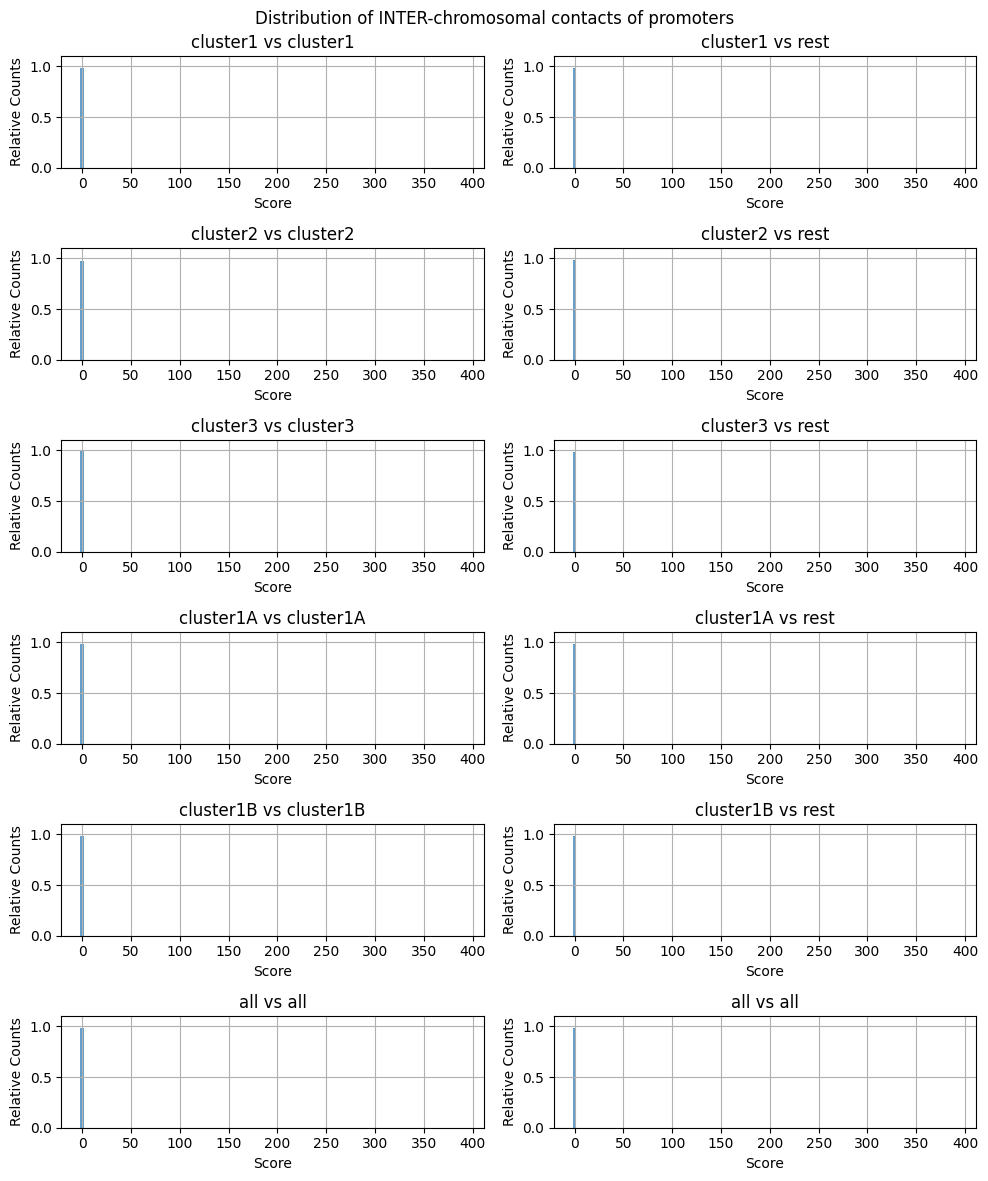

In [ ]:
# PLOT SCORE == 0.0 - INTER
clusters_comparisons_mod = [('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest'), ('all', 'all'), ('all', 'all')]

# INTER
png_path = results_folder + f'InterChr_contacts/' + 'CompositeFigure_0.png'
ylim, bar_width, title = 1.1, 3.5, 'Distribution of INTER-chromosomal contacts of promoters'
# Eliminate non-significative and above maximum score contacts
df = postresult_inter_df[postresult_inter_df['Score'] != 400.0]
PlotCompositeFig(df, clusters_comparisons_mod, png_path, ylim, bar_width, title)

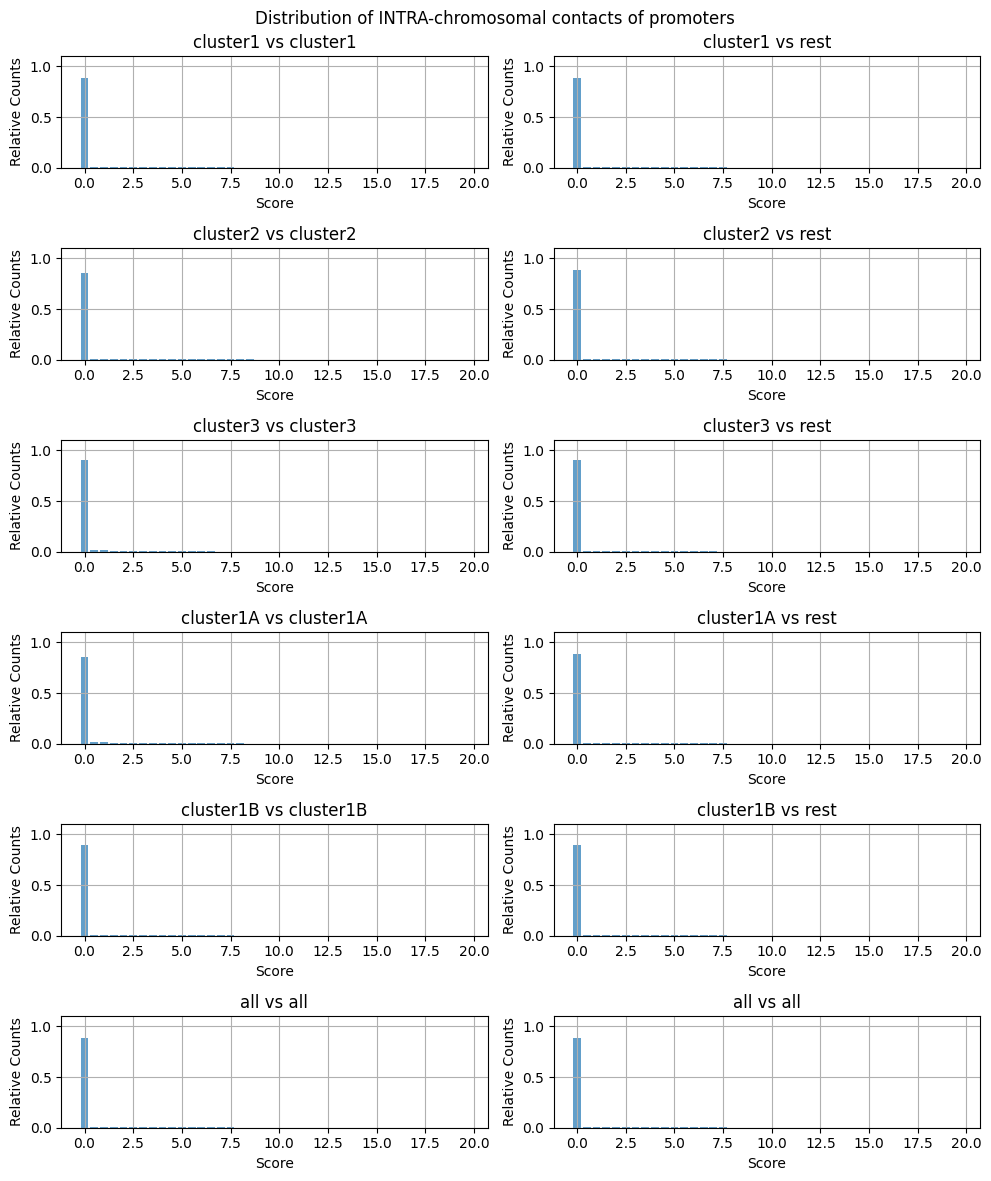

In [ ]:
# PLOT SCORE == 0.0 - INTRA

png_path = results_folder + f'IntraChr_contacts/' + 'CompositeFigure_0.png'
ylim, bar_width, title = 1.1, 0.4, 'Distribution of INTRA-chromosomal contacts of promoters'
# Eliminate non-significative and above maximum score contacts
df = postresult_intra_df[postresult_intra_df['Score'] != 20.0]
#df = postresult_intra_df

PlotCompositeFig(df, clusters_comparisons_mod, png_path, ylim, bar_width, title)

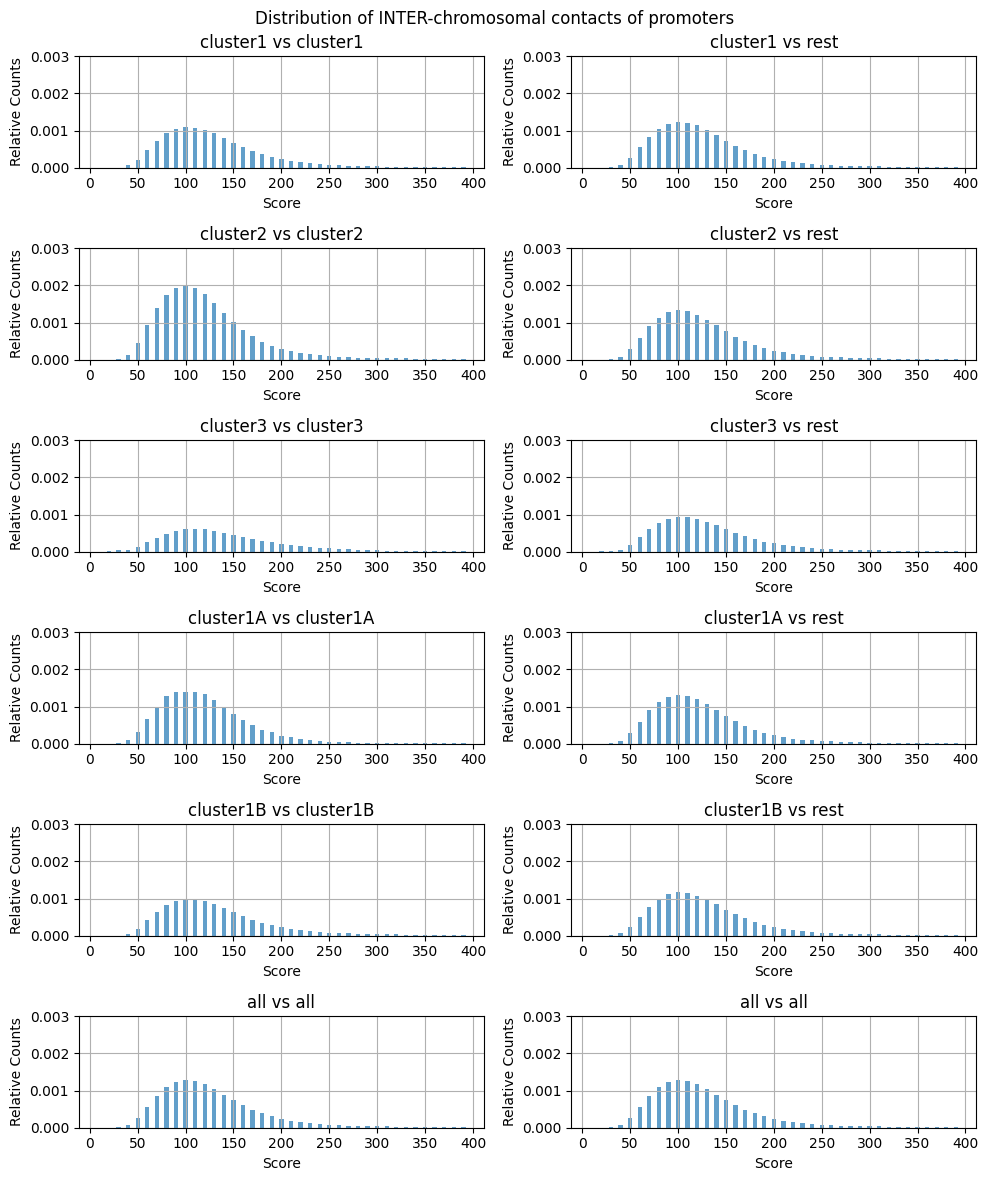

In [ ]:
clusters_comparisons_mod = [('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest'), ('all', 'all'), ('all', 'all')]

# INTER
png_path = results_folder + f'InterChr_contacts/' + 'CompositeFigure.png'
ylim, bar_width, title = 0.003, 4.5, 'Distribution of INTER-chromosomal contacts of promoters'
# Eliminate non-significative and above maximum score contacts
df = postresult_inter_df[(postresult_inter_df['Score'] != 0.0) & (postresult_inter_df['Score'] != 400.0)]

PlotCompositeFig(df, clusters_comparisons_mod, png_path, ylim, bar_width, title)

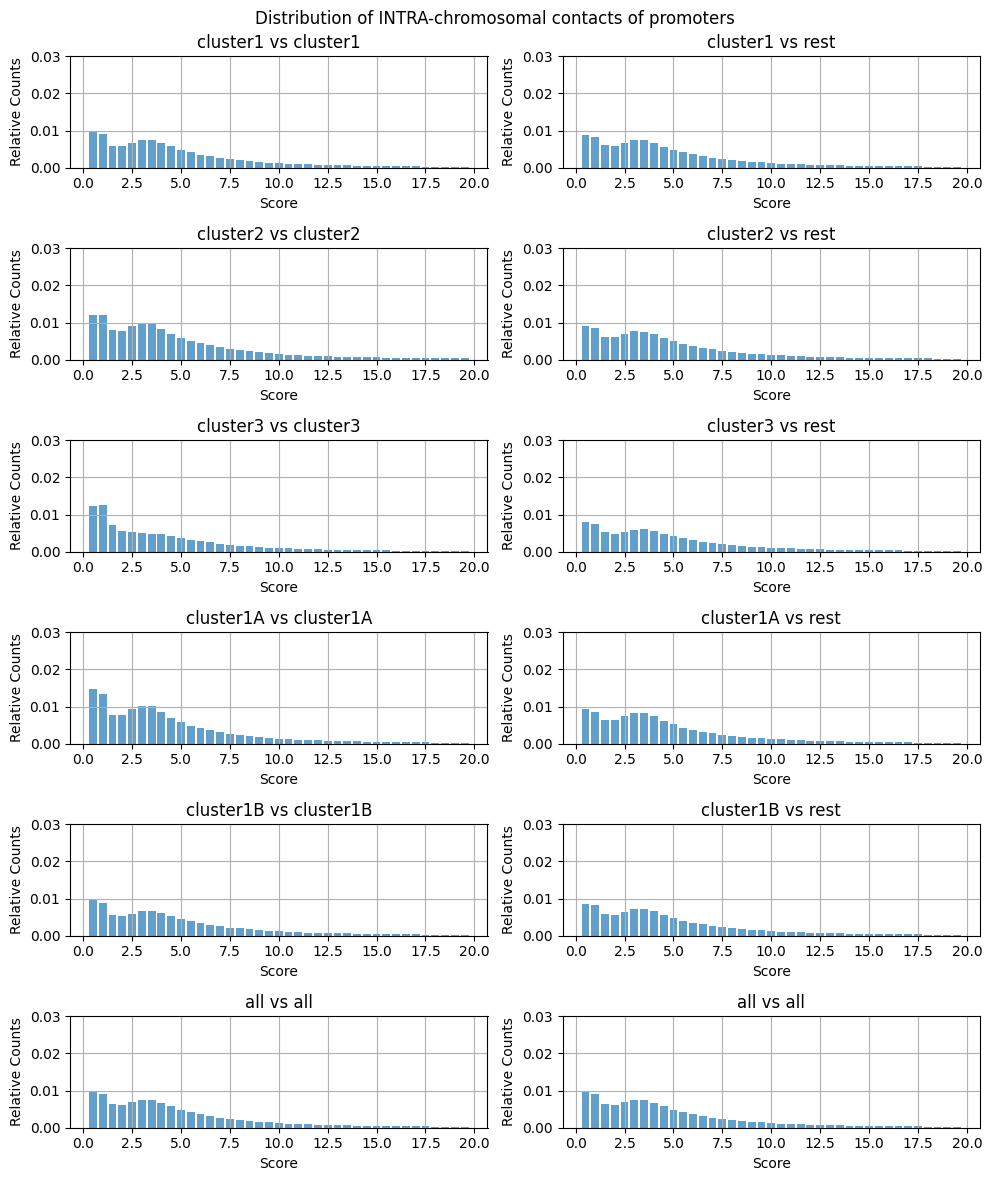

In [ ]:
# INTRA
png_path = results_folder + f'IntraChr_contacts/' + 'CompositeFigure.png'
ylim, bar_width, title = 0.03, 0.4, 'Distribution of INTRA-chromosomal contacts of promoters'
# Eliminate non-significative and above maximum score contacts
df = postresult_intra_df[(postresult_intra_df['Score'] != 0.0) & (postresult_intra_df['Score'] != 20.0)]
#df = postresult_intra_df

PlotCompositeFig(df, clusters_comparisons_mod, png_path, ylim, bar_width, title)

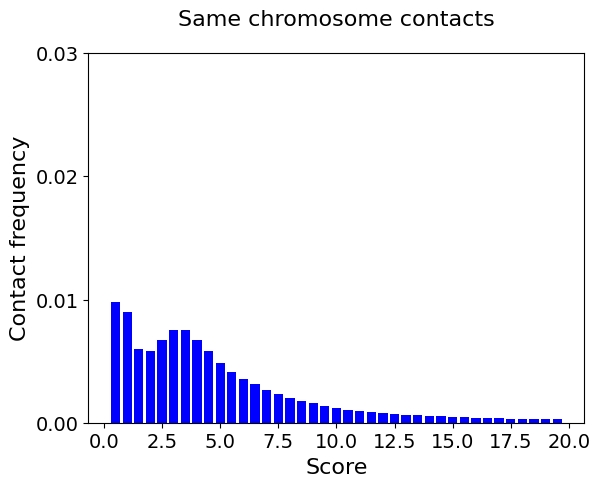

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

df = postresult_intra_df[(postresult_intra_df['Score'] != 0.0) & (postresult_intra_df['Score'] != 20.0)]
cluster2_df = df[(df['ClusterA'] == 'cluster1') & (df['ClusterB'] == 'cluster1')]

ylim, bar_width, title = 1.1, 0.4, 'Distribution of INTRA-chromosomal contacts of promoters'
size = 16

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the bars with desired color
bars = ax.bar(cluster2_df['Score'], cluster2_df['Relative Counts'], width=0.4, alpha=1.0, color='blue')

# Add labels and title
ax.set_xlabel('Score', fontsize=size)
ax.set_ylabel('Contact frequency', fontsize=size)
ax.set_title('Same chromosome contacts', fontsize=size, pad=20)

# Set x-ticks and y-ticks size
ax.tick_params(axis='x', labelsize=size-2)  # Set x-ticks size to 10
ax.tick_params(axis='y', labelsize=size-2)  # Set y-ticks size to 10

# Set y-ticks
ax.set_yticks([0.00, 0.01, 0.02, 0.03])

# Set x-ticks between 0 and 20 each 2.5
ax.set_xticks(np.arange(0, 21, 2.5))

plt.show()

# Show the plot

In [ ]:
def CalculateSigDF(combined_rel_df, significative_threshold):
    df = combined_rel_df.copy()

    columns = ['Category', 'ClusterA', 'ClusterB', 'Rel Counts Non Sig', 'Rel Counts Sig']
    new_df = pd.DataFrame(columns=columns)

    for clusterA, clusterB in clusters_comparisons:

      # Non-significative sum of Relative Counts
      filtered_rows_nonsig = df[(df['Score'] <= significative_threshold) & (df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)]
      sum_nonsig = filtered_rows_nonsig['Relative Counts'].sum()

      # Significative sum of Relative Counts
      filtered_rows_sig = df[(df['Score'] > significative_threshold) & (df['ClusterA'] == clusterA) & (df['ClusterB'] == clusterB)]
      sum_sig = filtered_rows_sig['Relative Counts'].sum()

      # Add new row
      new_row = {'Category': f'{clusterA}{clusterB}', 'ClusterA': clusterA, 'ClusterB': clusterB, 'Rel Counts Non Sig': sum_nonsig, 'Rel Counts Sig' : sum_sig}
      new_df.loc[len(new_df)] = new_row

    return new_df

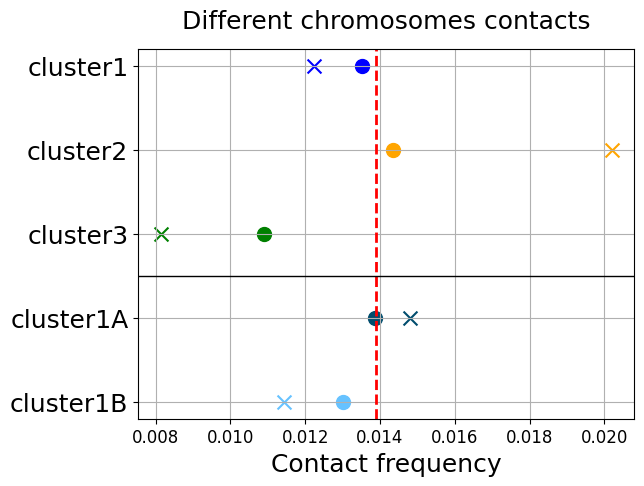

In [ ]:
# Define cluster comparisons, palette, and symbols
clusters_comparisons = [('all', 'all'), ('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest')]
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red'}
symbols = {'within cluster': 'x', 'outside cluster': 'o'}

y_axis_order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
y_axis_order =['cluster1B', 'cluster1A', 'cluster3','cluster2', 'cluster1']
size = 18
smaller_size = size - 6

# INTER
df = postresult_inter_df
csv_path = results_folder + f'InterChr_contacts/' + 'SignificativeComparison.csv'
png_path = results_folder + f'InterChr_contacts/' + 'SignificativeComparison.png'
title = 'Different chromosomes contacts'
significative_threshold = 1.0
x_vertical_line = 0.013881
read_flag = False

# Check if the CSV file exists and load it if read_flag is True
if os.path.exists(csv_path) and read_flag:
    print(csv_path, 'file already exists and will be loaded in df')
    sig_df = pd.read_csv(csv_path)
else:
    sig_df = CalculateSigDF(df, significative_threshold)


# Define the desired order of y-axis labels
y_axis_order =['cluster1B', 'cluster1A', 'cluster3','cluster2', 'cluster1']

# Plotting
for index, row in sig_df.iterrows():
    # Set marker based on ClusterB
    marker = symbols['within cluster'] if 'rest' not in row['ClusterB'] else symbols['outside cluster']
    if row['ClusterA'] == 'all':
        continue

    # Find the y-axis position for the current cluster
    y_position = y_axis_order.index(row['ClusterA'])
    # Plot the data point
    plt.scatter(row['Rel Counts Sig'], y_position, color=cluster_palette[row['ClusterA']], marker=marker, s=100, alpha=1.0, label='Within cluster' if 'rest' not in row['ClusterB'] else 'Outside cluster')

# Set title and labels
plt.axvline(x=x_vertical_line, color='red', linestyle='--', linewidth=2)
plt.title(title, fontsize=size, pad=15)
plt.xlabel('Contact frequency', fontsize=size)
plt.yticks(ticks=range(len(y_axis_order)), labels=y_axis_order, fontsize=size)  # Specify the order of the y-ticks
plt.xticks(fontsize=smaller_size)

plt.grid(True)

# Add horizontal line between cluster3 and cluster1A
plt.axhline(y=y_axis_order.index('cluster3') - 0.5, color='black', linestyle='-', linewidth=1)


# Show plot
plt.show()


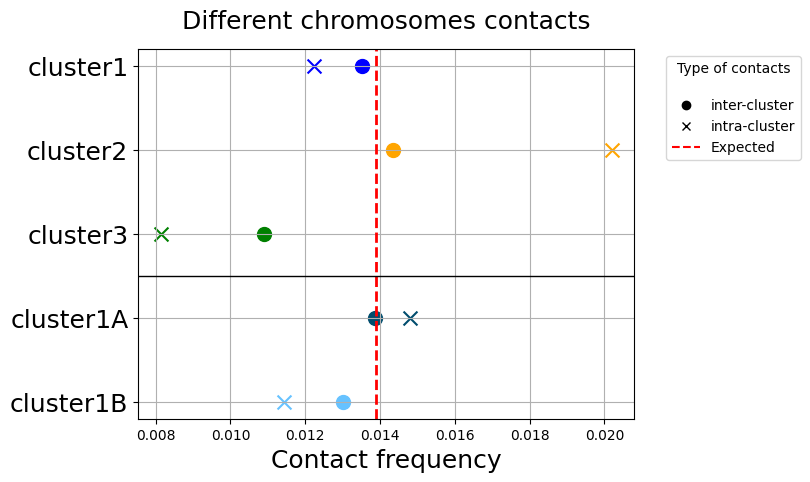

In [ ]:
# Define cluster comparisons, palette, and symbols
clusters_comparisons = [('all', 'all'), ('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest')]
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red'}
symbols = {'within cluster': 'x', 'outside cluster': 'o'}

y_axis_order = ['cluster1', 'cluster2', 'cluster3', 'cluster1A', 'cluster1B']
#y_axis_order = ['cluster1A', 'cluster1B', 'cluster3','cluster2', 'cluster1']
size = 18
smaller_size = size - 8

# INTER
df = postresult_inter_df
csv_path = results_folder + f'InterChr_contacts/' + 'SignificativeComparison.csv'
png_path = results_folder + f'InterChr_contacts/' + 'SignificativeComparison.png'
title = 'Different chromosomes contacts'
significative_threshold = 1.0
x_vertical_line = 0.013881
read_flag = False

# Check if the CSV file exists and load it if read_flag is True
if os.path.exists(csv_path) and read_flag:
    print(csv_path, 'file already exists and will be loaded in df')
    sig_df = pd.read_csv(csv_path)
else:
    sig_df = CalculateSigDF(df, significative_threshold)


# Define the desired order of y-axis labels
y_axis_order =['cluster1B', 'cluster1A', 'cluster3','cluster2', 'cluster1']

# Plotting
for index, row in sig_df.iterrows():
    # Set marker based on ClusterB
    marker = symbols['within cluster'] if 'rest' not in row['ClusterB'] else symbols['outside cluster']
    if row['ClusterA'] == 'all':
        continue

    # Find the y-axis position for the current cluster
    y_position = y_axis_order.index(row['ClusterA'])
    # Plot the data point
    plt.scatter(row['Rel Counts Sig'], y_position, color=cluster_palette[row['ClusterA']], marker=marker, s=100, alpha=1.0, label='Within cluster' if 'rest' not in row['ClusterB'] else 'Outside cluster')

# Set title and labels
plt.axvline(x=x_vertical_line, color='red', linestyle='--', linewidth=2)
plt.title(title, fontsize=size, pad=15)
plt.xlabel('Contact frequency', fontsize=size)
plt.yticks(ticks=range(len(y_axis_order)), labels=y_axis_order, fontsize=size)  # Specify the order of the y-ticks
plt.xticks(fontsize=smaller_size)

plt.grid(True)

# Add horizontal line between cluster3 and cluster1A
plt.axhline(y=y_axis_order.index('cluster3') - 0.5, color='black', linestyle='-', linewidth=1)

# Add legend
plt.legend(handles=[plt.Line2D([], [], marker='o', color='black', linestyle='None'),
                    plt.Line2D([], [], marker='x', color='black', linestyle='None'),
                    plt.Line2D([], [], color='red', linestyle='--')],
            labels=['inter-cluster', 'intra-cluster', 'Expected'],
            title='Type of contacts\n', loc='upper right', bbox_to_anchor=(1.35, 1))
plt.savefig(results_folder + "inter.png", bbox_inches='tight')

# Show plot
plt.show()

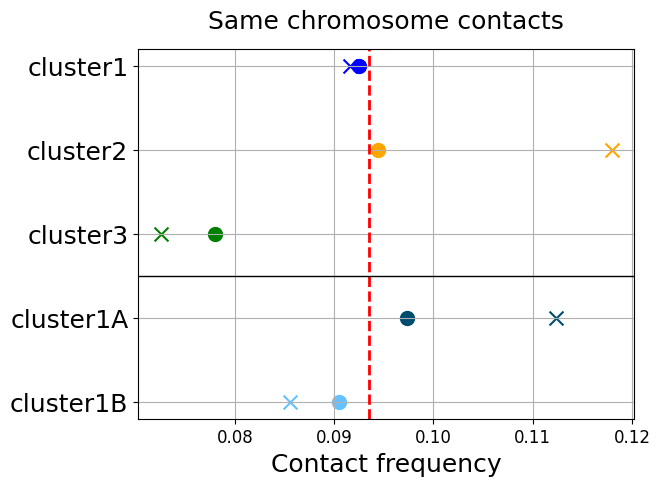

In [ ]:
# INTRA
df = postresult_intra_df
csv_path = results_folder + f'IntraChr_contacts/' + 'SignificativeComparison.csv'
png_path = results_folder + f'IntraChr_contacts/' + 'SignificativeComparison.png'
title = 'Same chromosome contacts'
significative_threshold = 1.0
x_vertical_line = 0.093531
#x_vertical_line2 = 0.906469

if os.path.exists(csv_path):
  print(csv_path, 'file already exists and will be loaded in df')
  sig_df = pd.read_csv(csv_path)
else:
  sig_df = CalculateSigDF(df, significative_threshold)
  #sig_df.to_csv(csv_path)


# Define the desired order of y-axis labels
y_axis_order =['cluster1B', 'cluster1A', 'cluster3','cluster2', 'cluster1']

# Plotting
for index, row in sig_df.iterrows():
    # Set marker based on ClusterB
    marker = symbols['within cluster'] if 'rest' not in row['ClusterB'] else symbols['outside cluster']
    if row['ClusterA'] == 'all':
        continue

    # Find the y-axis position for the current cluster
    y_position = y_axis_order.index(row['ClusterA'])
    # Plot the data point
    plt.scatter(row['Rel Counts Sig'], y_position, color=cluster_palette[row['ClusterA']], marker=marker, s=100, alpha=1.0, label='Within cluster' if 'rest' not in row['ClusterB'] else 'Outside cluster')

# Set title and labels
plt.axvline(x=x_vertical_line, color='red', linestyle='--', linewidth=2)
plt.title(title, fontsize=size, pad=15)
plt.xlabel('Contact frequency', fontsize=size)
plt.yticks(ticks=range(len(y_axis_order)), labels=y_axis_order, fontsize=size)  # Specify the order of the y-ticks
plt.xticks(fontsize=smaller_size)

plt.grid(True)

# Add horizontal line between cluster3 and cluster1A
plt.axhline(y=y_axis_order.index('cluster3') - 0.5, color='black', linestyle='-', linewidth=1)

plt.savefig(results_folder + "intra.png", bbox_inches='tight')

# Show plot
plt.show()

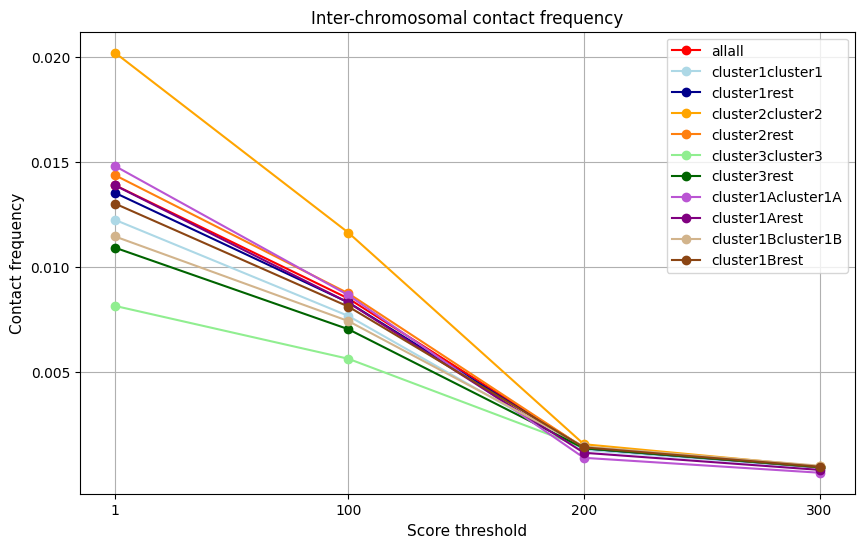

In [ ]:
clusters_comparisons = [('all', 'all'), ('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest')]
sig_thresholds = [1.0, 100.0, 200.0, 300.0]

category_colors = {
    'allall': 'red',
    'cluster1cluster1': 'lightblue',
    'cluster1rest': 'darkblue',
    'cluster2cluster2': 'orange',
    'cluster2rest': '#ff7f0e',
    'cluster3cluster3': 'lightgreen',
    'cluster3rest': 'darkgreen',
    'cluster1Acluster1A': '#BA55D3',
    'cluster1Arest': '#800080',
    'cluster1Bcluster1B': '#D2B48C',
    'cluster1Brest': '#8B4513'
}

columns = ['threshold', 'Category', 'ClusterA', 'ClusterB', 'Rel Counts Non Sig', 'Rel Counts Sig']
sig_df = pd.DataFrame(columns=columns)

# INTER
for thres in sig_thresholds:
  df = CalculateSigDF(postresult_inter_df, thres)
  df['threshold'] = thres

  sig_df = pd.concat([sig_df, df], ignore_index=True)

df = sig_df.copy()
categories = df['Category'].unique()

plt.figure(figsize=(10, 6))

for category, color in category_colors.items():
    category_data = df[df['Category'] == category]
    plt.plot(category_data['threshold'], category_data['Rel Counts Sig'], marker='o', label=category, color=color)

# Add labels and title
plt.xlabel('Score threshold', fontsize=11)
plt.ylabel('Contact frequency' , fontsize=11)
plt.title('Inter-chromosomal contact frequency')
plt.xticks(sig_thresholds, fontsize=10)
plt.yticks([0.005, 0.01, 0.015, 0.02], fontsize=10)

plt.legend()
plt.grid(True)

# Show plot
plt.show()

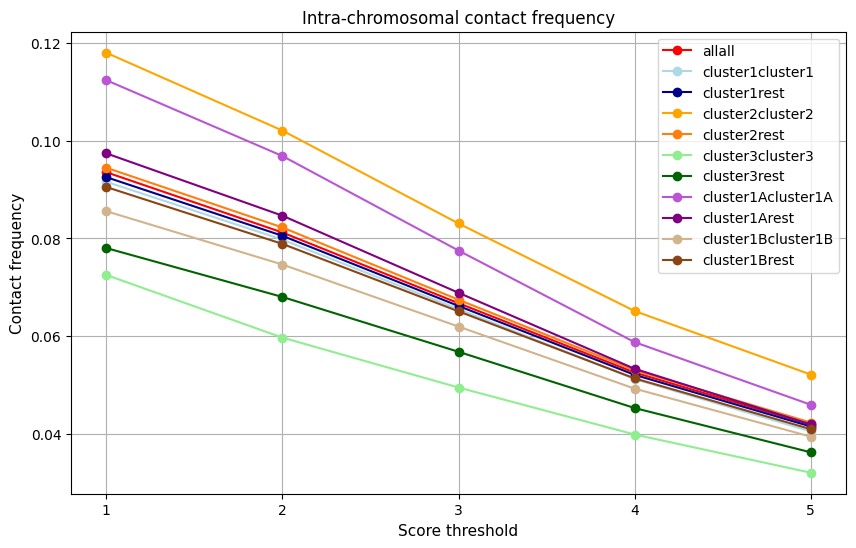

In [ ]:
clusters_comparisons = [('all', 'all'), ('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest')]
sig_thresholds = [1.0, 2.0, 3.0, 4.0, 5.0]

category_colors = {
    'allall': 'red',
    'cluster1cluster1': 'lightblue',
    'cluster1rest': 'darkblue',
    'cluster2cluster2': 'orange',
    'cluster2rest': '#ff7f0e',
    'cluster3cluster3': 'lightgreen',
    'cluster3rest': 'darkgreen',
    'cluster1Acluster1A': '#BA55D3',
    'cluster1Arest': '#800080',
    'cluster1Bcluster1B': '#D2B48C',
    'cluster1Brest': '#8B4513'
}

columns = ['threshold', 'Category', 'ClusterA', 'ClusterB', 'Rel Counts Non Sig', 'Rel Counts Sig']
sig_df = pd.DataFrame(columns=columns)

# INTER
for thres in sig_thresholds:
  df = CalculateSigDF(postresult_intra_df, thres)
  df['threshold'] = thres

  sig_df = pd.concat([sig_df, df], ignore_index=True)

df = sig_df.copy()
categories = df['Category'].unique()

plt.figure(figsize=(10, 6))

for category, color in category_colors.items():
    category_data = df[df['Category'] == category]
    plt.plot(category_data['threshold'], category_data['Rel Counts Sig'], marker='o', label=category, color=color)

# Add labels and title
plt.xlabel('Score threshold', fontsize=11)
plt.ylabel('Contact frequency' , fontsize=11)
plt.title('Intra-chromosomal contact frequency')
plt.xticks(sig_thresholds, fontsize=10)
#plt.yticks([0.005, 0.01, 0.015, 0.02], fontsize=10)

plt.legend()
plt.grid(True)

# Show plot
plt.show()


# **4. Analysis of the 3D chromatin interactions among promoters in the clusters of genes: PC Hi-C map of contacts (*Schoenfelder et al. 2015*)**

The following steps are included in the analysis:

1.   Define initial variables and file/folder paths
2.   Load promoter instances and eliminate promoters not included in the list of contacts from mm9 *Schoenfelder et al. 2015*
3.   Permutation analysis: contacts for the real clusters ('observed') and randomized clusters ('permuted')
4.   Plot z-score and distributions of the permutation analysis: compare 'observed' and 'permuted' contacts

**1.   Define initial variables and file/folder paths**

In [ ]:
drive_folder = "/content/drive/My Drive/Miguel_TFM"

# Classes_folder
classes_folder = drive_folder + "/Part3.Gene_Interactions/"

# Matrix file path
matrix_filepath = drive_folder + "/Part3.Gene_Interactions/" + "4DNFI4OUMWZ8.hic"

# Promoters coordinates folder
promoters_folder = drive_folder + "/Promoters_clusters_NEW"

# Our promoters PCHiC contacts
ourpromoters_PCHiCcontacts_filepath = drive_folder + "/Part3.Gene_Interactions/" + "our_promoters_PCHiCcontacts.txt"

# List of missing promoters
missing_promoters_filepath = drive_folder + "/Part3.Gene_Interactions/" + "Ali_missing_promoters.txt"

# mm10 ESC significant interactions of PC-HiC (Schoenfelder et al. 2015)
#mm10_PCHiC_interactions_filepath = drive_folder + "/Part3.Gene_Interactions/" + "mm10_ESC_promoter_promoter_significant_interactions.txt"

In [ ]:
# Import packages and Drive
#!pip install hic-straw

import numpy as np
import pandas as pd
#import hicstraw
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import itertools
import random
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
from types import MappingProxyType
from google.colab import drive
drive.mount('/content/drive')

from collections import Counter
import statistics

# Import classes: Feature, Promoter and Contact
sys.path.append(classes_folder)
from Contact import Contact
from Promoter import Promoter

Mounted at /content/drive


In [ ]:
def LoadPromoterObjects(clusters_path):
  # Load promoter instances from bedfile
  cluster_pattern = r"_([^_]*)cluster([^_]*)_"
  cluster_names = []

  if os.path.exists(clusters_path):
      files = os.listdir(clusters_path)

      for file in files:
          cluster_match = re.search(cluster_pattern, file)
          cluster_name = cluster_match.group(0).strip('_')
          cluster_names.append(cluster_name)
          file_path = clusters_path + "/" + file
          print(file_path, cluster_name)
          Promoter.LoadFromBedfile(file_path, cluster_name)
  else:
      print("The specified directory does not exist.")

def CreateFolder(folder_path):
  # Check if the directory exists
  if not os.path.exists(folder_path):
      # Create the directory if it doesn't exist
      os.makedirs(folder_path)
      print("Folder", folder_path, "created successfully.")
  else:
      print("Folder",folder_path, "already exists.")

In [ ]:
# Create results folder if not existing
results_folder = drive_folder + "/Part3.Gene_Interactions/" + "results_vPCHiC/" + "1000_permutations_cluster1/"
CreateFolder(results_folder)

Folder /content/drive/My Drive/Miguel_TFM/Part3.Gene_Interactions/results_vPCHiC/1000_permutations_cluster1/ already exists.


In [ ]:
# Get Promoter Objects
LoadPromoterObjects(promoters_folder)

/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster1B_coord.bed cluster1B
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster1A_coord.bed cluster1A
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster2_coord.bed cluster2
/content/drive/My Drive/Miguel_TFM/Promoters_clusters_NEW/All_promoters_cluster3_coord.bed cluster3


**2.   Load promoter instances and eliminate promoters not included in the list of contacts from mm9 Schoenfelder et al. 2015**

In [ ]:
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
for cluster in clusters:
  promoters = Promoter.RetrieveClusterMembers(cluster)
  print(cluster, '\t', len(promoters))

cluster1A 	 2581
cluster1B 	 6001
cluster2 	 7988
cluster3 	 4049


In [ ]:
missing_identifiers = []
with open(missing_promoters_filepath, "r") as file:
    for line in file:
      line = line.rstrip('\n')
      missing_identifiers.append(line)
print(len(missing_identifiers))

3918


In [ ]:
print(missing_identifiers)

['0610010B08Rik', '1110012L19Rik', '1110034G24Rik', '1190003K10Rik', '1190007I07Rik', '1600014C23Rik', '1700001F09Rik', '1700007K09Rik', '1700010D01Rik', '1700011L22Rik', '1700012L04Rik', '1700012P22Rik', '1700013F07Rik', '1700013H16Rik', '1700015G11Rik', '1700016H13Rik', '1700017B05Rik', '1700018F24Rik', '1700019D03Rik', '1700019O17Rik', '1700028K03Rik', '1700029F12Rik', '1700030F18Rik', '1700031F05Rik', '1700047I17Rik2', '1700049G17Rik', '1700066B19Rik', '1700067P10Rik', '1700071K01Rik', '1700080E11Rik', '1700122O11Rik', '1700123K08Rik', '1810009J06Rik', '2010005H15Rik', '2010107G23Rik', '2010109I03Rik', '2010315B03Rik', '2210010C04Rik', '2210013O21Rik', '2210404O09Rik', '2210407C18Rik', '2210418O10Rik', '2310034C09Rik', '2410141K09Rik', '2610008E11Rik', '2610042L04Rik', '2610044O15Rik8', '2610305D13Rik', '2610528A11Rik', '2700097O09Rik', '3110052M02Rik', '3110082I17Rik', '3300002I08Rik', '3425401B19Rik', '3830403N18Rik', '4921509C19Rik', '4921511M17Rik', '4921524J17Rik', '4922502D21

In [ ]:
our_promoters = []
for promoter in Promoter.all_promoters.values():
  if promoter.identifier in missing_identifiers:
    our_promoters.append(promoter)
print(len(our_promoters))

3918


In [ ]:
print(our_promoters)

[<Feature2_v7.Promoter object at 0x79548ca3b550>, <Feature2_v7.Promoter object at 0x79544e7abfd0>, <Feature2_v7.Promoter object at 0x79544e7abd30>, <Feature2_v7.Promoter object at 0x79544e7abcd0>, <Feature2_v7.Promoter object at 0x79544e7aba60>, <Feature2_v7.Promoter object at 0x79544e814040>, <Feature2_v7.Promoter object at 0x79544e8140a0>, <Feature2_v7.Promoter object at 0x79544e8140d0>, <Feature2_v7.Promoter object at 0x79544e814220>, <Feature2_v7.Promoter object at 0x79544e8143a0>, <Feature2_v7.Promoter object at 0x79544e814430>, <Feature2_v7.Promoter object at 0x79544e814460>, <Feature2_v7.Promoter object at 0x79544e814520>, <Feature2_v7.Promoter object at 0x79544e8145b0>, <Feature2_v7.Promoter object at 0x79544e8146a0>, <Feature2_v7.Promoter object at 0x79544e814a90>, <Feature2_v7.Promoter object at 0x79544e814d60>, <Feature2_v7.Promoter object at 0x79544e814d90>, <Feature2_v7.Promoter object at 0x79544e814eb0>, <Feature2_v7.Promoter object at 0x79544e814ee0>, <Feature2_v7.Promot

In [ ]:
for promoter in our_promoters:
  promoter.DeleteInstance()

In [ ]:
clusters = ['cluster1A', 'cluster1B', 'cluster2', 'cluster3']
for cluster in clusters:
  promoters = Promoter.RetrieveClusterMembers(cluster)
  print(cluster, '\t', len(promoters))

cluster1A 	 2297
cluster1B 	 4711
cluster2 	 6741
cluster3 	 2952


In [ ]:
print(len(Promoter.all_promoters))
#print(Promoter.all_promoters['Egfl7'])

16701


**3.   Permutation analysis: contacts for the real clusters ('observed') and randomized clusters ('permuted')**

- 1. **Null hypothesis**: there is no difference between the number of interactions observed for each cluster comparison and what would be obtained by chance for a given number of promoters. * Could be extended to mean of interactions per promoter, ... Now we will only do it with number of total interactions for each cluster comparison

- 2. Calculate the **Observed Data** to test: n_interactions_counts (DONE)

- 3. For n=number of **permutations**, permute/randomize the four clusters of promoters (keeping the n_promoters and randomize them together so the 4 of them make the total) -> calculate n_interactions_counts for each cluster -> save iteration values in df

- 4. Compare the Observed Data with values for permutations (**p-value**):

p_value = (np.sum(permuted_statistics >= observed_statistic) + 1) (num_permutations + 1)

- 5. Draw Conclusions
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

In [ ]:
def CountInteractions(df):
  promoters_dict = Promoter.all_promoters

  data_interactions = []
  all_int_per_prom = []

  for clusterA, clusterB in cluster_combinations:

      values = []
      Promoter.RestartNInteractions()
      with open(ourpromoters_PCHiCcontacts_filepath, "r") as file:
          for line in file:
              # Split the line into columns separated by space
              columns = line.split()
              identifier_1, identifier_2, score = columns[1], columns[2], columns[3]
              promoter1, promoter2 = promoters_dict[identifier_1], promoters_dict[identifier_2]

              # Depending on clusterA, clusterB, keep score interaction
              if clusterA == "all" and clusterB == "all":
                  values.append(score)
                  # Sum 1 to the number of interactions
                  promoter1.n_interactions += 1
                  promoter2.n_interactions += 1

              elif clusterB == "rest":
                  if (clusterA == promoter1.cluster and clusterA != promoter2.cluster) or \
                          (clusterA == promoter2.cluster and clusterA != promoter1.cluster):
                      values.append(score)
                      # Sum 1 to the number of interactions
                      promoter1.n_interactions += 1
                      promoter2.n_interactions += 1
              else:
                  if (clusterA == promoter1.cluster and clusterB == promoter2.cluster) or \
                          (clusterA == promoter2.cluster and clusterB == promoter1.cluster):
                      values.append(score)
                      # Sum 1 to the number of interactions
                      promoter1.n_interactions += 1
                      promoter2.n_interactions += 1

      # Calculate media of n_interactions per promoter
      clusterA_promoters = Promoter.RetrieveClusterMembers(clusterA)
      n_interactions_perpromoter = [promoter.n_interactions for promoter in clusterA_promoters]
      if clusterB == 'rest':
        clusterB_promoters = Promoter.RetrieveClusterMembers(clusterA, rest='Yes')
        n_interactions_perpromoter.extend(promoter.n_interactions for promoter in clusterB_promoters)
      mean = statistics.mean(n_interactions_perpromoter)

      # Calculate n_promoters_interacting
      n_nonzero_interactions = np.count_nonzero(n_interactions_perpromoter)

      # Append data to dataframe
      #new_row = {'n_permutation': permutation, 'clusterA' : clusterA, 'clusterB' : clusterB, 'n_interactions': len(values), 'mean_interactions_per_promoter': mean, 'total_promoters_interacting' : n_nonzero_interactions}
      df.loc[len(df)] = [permutation, clusterA, clusterB, len(values), mean, n_nonzero_interactions]

  return df

In [ ]:
all_promoters = Promoter.all_promoters
for prom in all_promoters.values():
  if prom.cluster == 'cluster1A' or prom.cluster == 'cluster1B':
    prom.cluster = 'cluster1'

In [ ]:
# Define some parameters...
cluster_sizes = {
    'cluster1': 7008,
    'cluster2': 6741,
    'cluster3': 2952
}

cluster_combinations = [
    ("all", "all"),
    ("cluster1", "cluster1"),
    ("cluster1", "rest"),
    ("cluster2", "cluster2"),
    ("cluster2", "rest"),
    ("cluster3", "cluster3"),
    ("cluster3", "rest"),
]

n_genes = {"all": 16701, "cluster1" : 7008, "cluster2" : 6741, "cluster3" : 2952}

n_permutations = 1000 # 100 permutations: 0 to 99
check_points = [20, 40 ,60, 80, 100]

In [ ]:
# Calculate dataframe with REAL clusters: OBSERVED statistic
csv_path = results_folder + 'observed.csv'

if os.path.exists(csv_path):
  df_observed = pd.read_csv(csv_path)
else:
  columns = ['n_permutation', 'clusterA', 'clusterB', 'n_interactions', 'mean_interactions_per_promoter', 'total_promoters_interacting']
  df_observed = pd.DataFrame(columns=columns)
  permutation = 'Observed'
  df_observed = CountInteractions(df_observed)
  df_observed.to_csv(csv_path, index=False)

df_observed

,n_permutation,clusterA,clusterB,n_interactions,mean_interactions_per_promoter,total_promoters_interacting
0,Observed,all,all,356187,42.654572,16701
1,Observed,cluster1,cluster1,54989,15.693208,6976
2,Observed,cluster1,rest,164626,19.714508,16624
3,Observed,cluster2,cluster2,76343,22.650349,6702
4,Observed,cluster2,rest,168898,20.226094,16541
5,Observed,cluster3,cluster3,12901,8.740515,2844
6,Observed,cluster3,rest,90384,10.823783,16157


In [ ]:
# Calculate dataframe with ARTIFICIAL clusters: PERMUTED statistic

csv_path = results_folder + 'permuted.csv'
read_flag = True

if os.path.exists(csv_path) and read_flag:
  df_permuted = pd.read_csv(csv_path)
else:
  columns = ['n_permutation', 'clusterA', 'clusterB', 'n_interactions', 'mean_interactions_per_promoter', 'total_promoters_interacting']
  df_permuted = pd.DataFrame(columns=columns)
  for permutation in range(n_permutations):
    # Create random clusters
    Promoter.CreateRandomClusters(cluster_sizes)

    # Count interactions
    df_permuted = CountInteractions(df_permuted)

    # Save as csv
    df_permuted.to_csv(csv_path, index=False)

df_permuted

,n_permutation,clusterA,clusterB,n_interactions,mean_interactions_per_promoter,total_promoters_interacting
0,0,all,all,356187,42.654572,16701
1,0,cluster1,cluster1,60630,17.303082,6969
2,0,cluster1,rest,172904,20.705826,16630
3,0,cluster2,cluster2,60174,17.850489,6703
4,0,cluster2,rest,172417,20.647506,16617
...,...,...,...,...,...,...
6995,999,cluster1,rest,173950,20.831088,16628
6996,999,cluster2,cluster2,57106,16.942887,6713
6997,999,cluster2,rest,171178,20.499132,16616
6998,999,cluster3,cluster3,10975,7.438157,2846


In [ ]:
from scipy.stats import norm
from scipy.stats import kstest

columns = ['clusterA', 'clusterB', 'n_interactions', 'mean_interactions_per_promoter', 'total_promoters_interacting']
df_pvalues2 = pd.DataFrame(columns=columns)

for clusterA, clusterB in cluster_combinations:

    new_row = {key: 0 for key in columns}
    new_row['clusterA'] = clusterA
    new_row['clusterB'] = clusterB
    # Obtain dataframe for clusterA, clusterB
    categorical_df = df_permuted[(df_permuted['clusterA'] == clusterA) & (df_permuted['clusterB'] == clusterB)]

    for column in ['n_interactions', 'mean_interactions_per_promoter', 'total_promoters_interacting']:
      permuted_data = categorical_df[column].values
      mu, std = np.mean(permuted_data), np.std(permuted_data)

      # Create a normal distribution using the estimated parameters
      normal_dist = norm(loc=mu, scale=std)

      # Kolmogorov-Smirnov test for goodness of fit of our data to a normal distributionn
      statistic, p_value = kstest(permuted_data, normal_dist.cdf)

      #If the p-value is high (e.g., greater than 0.05), it suggests that the data is likely to be drawn from the normal distribution.
      if p_value < 0.05:
        print("Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data:", clusterA, clusterB, column, statistic, p_value)

      # Once we know that it follows a normal distribution, we calculate probability of the observed value
      observed_value = df_observed.loc[(df_observed['clusterA'] == clusterA) & (df_observed['clusterB'] == clusterB), column].iloc[0]
      pdf_at_obs = normal_dist.pdf(observed_value) # p-value or probability of finding the value in the random distribution

      new_row[column] = pdf_at_obs

    df_pvalues2.loc[len(df_pvalues2)] = new_row
df_pvalues2

Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data: all all mean_interactions_per_promoter 0.8413447460685429 0.0
Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data: cluster1 cluster1 total_promoters_interacting 0.05281000700980415 0.007283812801602757
Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data: cluster2 cluster2 total_promoters_interacting 0.04551197813366381 0.03078027229406155
Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data: cluster2 rest total_promoters_interacting 0.05937273087874151 0.001660427439901258


/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


,clusterA,clusterB,n_interactions,mean_interactions_per_promoter,total_promoters_interacting
0,all,all,NaN,1.702718e+13,NaN
1,cluster1,cluster1,9.207893e-23,3.377953e-19,2.816809e-02
2,cluster1,rest,6.943098e-95,5.797834e-91,4.266975e-02
3,cluster2,cluster2,1.323791e-116,3.672384e-113,5.500104e-02
4,cluster2,rest,1.439260e-09,1.201854e-05,1.483087e-22
5,cluster3,cluster3,2.348796e-11,3.607326e-08,3.612478e-02
6,cluster3,rest,1.848100e-40,1.543256e-36,6.773300e-03


The z-score represents the distance between an observed value and the mean of a distribution in terms of standard deviations.

In the context of your code, the z-score is calculated for each observed value compared to the mean and standard deviation of the permuted distribution. It tells you how many standard deviations the observed value is away from the mean of the distribution.

The z-score distance, therefore, is simply the value of the z-score itself. A higher absolute z-score indicates that the observed value is further from the mean of the distribution.

For example:

If the z-score is 0, it means the observed value is exactly at the mean of the distribution.
If the z-score is +1, it means the observed value is one standard deviation above the mean.
If the z-score is -1, it means the observed value is one standard deviation below the mean.
So, the distance of the observed value to the permuted distribution is given by the z-score.

In [ ]:
# N_INTERACTIONS ONLY

from scipy.stats import norm
from scipy.stats import kstest
import pandas as pd

df_permuted = pd.read_csv(results_folder + 'permuted.csv')
df_observed = pd.read_csv(results_folder + 'observed.csv')

cluster_combinations = [
    ("all", "all"),
    ("cluster1", "cluster1"),
    ("cluster1", "rest"),
    ("cluster2", "cluster2"),
    ("cluster2", "rest"),
    ("cluster3", "cluster3"),
    ("cluster3", "rest"),
]

columns = ['clusterA', 'clusterB', 'p-val', 'z-score distance']
df_zscore_c1 = pd.DataFrame(columns=columns)

for clusterA, clusterB in cluster_combinations:

    new_row = {key: None for key in columns}
    new_row['clusterA'] = clusterA
    new_row['clusterB'] = clusterB
    # Obtain dataframe for clusterA, clusterB
    categorical_df = df_permuted[(df_permuted['clusterA'] == clusterA) & (df_permuted['clusterB'] == clusterB)]

    column = 'n_interactions'
    permuted_data = categorical_df[column].values
    mu, std = np.mean(permuted_data), np.std(permuted_data)

    # Create a normal distribution using the estimated parameters
    normal_dist = norm(loc=mu, scale=std)

    # Kolmogorov-Smirnov test for goodness of fit of our data to a normal distribution
    statistic, p_value = kstest(permuted_data, normal_dist.cdf)

    # If the p-value is high (e.g., greater than 0.05), it suggests that the data is likely to be drawn from the normal distribution.
    if p_value < 0.05:
        print("Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data:", clusterA, clusterB, column, statistic, p_value)

    # Once we know that it follows a normal distribution, we calculate probability of the observed value
    observed_value = df_observed.loc[(df_observed['clusterA'] == clusterA) & (df_observed['clusterB'] == clusterB), column].iloc[0]
    pdf_at_obs = normal_dist.pdf(observed_value)  # p-value or probability of finding the value in the random distribution

    # Calculate z-score
    z_score = (observed_value - mu) / std

    new_row[column] = {'pdf_at_obs': pdf_at_obs, 'z_score': z_score}
    new_row = {'clusterA':clusterA, 'clusterB':clusterB, 'p-val':pdf_at_obs, 'z-score distance':z_score}

    df_zscore_c1.loc[len(df_zscore_c1)] = new_row


df_zscore_c1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-54-193552ffabb0>:50: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (observed_value - mu) / std


,clusterA,clusterB,p-val,z-score distance
0,all,all,NaN,NaN
1,cluster1,cluster1,9.207893e-23,-9.283375
2,cluster1,rest,6.943098e-95,-20.485322
3,cluster2,cluster2,1.323791e-116,22.768844
4,cluster2,rest,1.439260e-09,-5.147934
5,cluster3,cluster3,2.348796e-11,5.979964
6,cluster3,rest,1.848100e-40,-12.933512


In [ ]:
# N_INTERACTIONS ONLY

results_folder_1A1B =  drive_folder + "/Part3.Gene_Interactions/" + "results_vPCHiC/" + "1000_permutations/"

df_permuted = pd.read_csv(results_folder_1A1B + 'permuted.csv')
df_observed = pd.read_csv(results_folder_1A1B + 'observed.csv')

columns = ['clusterA', 'clusterB', 'p-val', 'z-score distance']
df_zscore_c1A1B = pd.DataFrame(columns=columns)

cluster_combinations = [
    ("all", "all"),
    ("cluster1A", "cluster1A"),
    ("cluster1A", "rest"),
    ("cluster1B", "cluster1B"),
    ("cluster1B", "rest"),
    ("cluster2", "cluster2"),
    ("cluster2", "rest"),
    ("cluster3", "cluster3"),
    ("cluster3", "rest"),
]

for clusterA, clusterB in cluster_combinations:

    new_row = {key: None for key in columns}
    new_row['clusterA'] = clusterA
    new_row['clusterB'] = clusterB
    # Obtain dataframe for clusterA, clusterB
    categorical_df = df_permuted[(df_permuted['clusterA'] == clusterA) & (df_permuted['clusterB'] == clusterB)]

    if not categorical_df.empty:

      column = 'n_interactions'
      permuted_data = categorical_df[column].values
      mu, std = np.mean(permuted_data), np.std(permuted_data)

      # Create a normal distribution using the estimated parameters
      normal_dist = norm(loc=mu, scale=std)

      # Kolmogorov-Smirnov test for goodness of fit of our data to a normal distribution
      statistic, p_value = kstest(permuted_data, normal_dist.cdf)

      # If the p-value is high (e.g., greater than 0.05), it suggests that the data is likely to be drawn from the normal distribution.
      if p_value < 0.05:
          print("Hey, Kolmogorov-Smirnov test statistic and p-value do not suggest normal distribution of data:", clusterA, clusterB, column, statistic, p_value)

      # Once we know that it follows a normal distribution, we calculate probability of the observed value
      observed_value = df_observed.loc[(df_observed['clusterA'] == clusterA) & (df_observed['clusterB'] == clusterB), column].iloc[0]
      pdf_at_obs = normal_dist.pdf(observed_value)  # p-value or probability of finding the value in the random distribution

      # Calculate z-score
      z_score = (observed_value - mu) / std

      new_row[column] = {'pdf_at_obs': pdf_at_obs, 'z_score': z_score}
      new_row = {'clusterA':clusterA, 'clusterB':clusterB, 'p-val':pdf_at_obs, 'z-score distance':z_score}

      df_zscore_c1A1B.loc[len(df_zscore_c1A1B)] = new_row



df_zscore_c1A1B

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-55-5f6e91d4b820>:52: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (observed_value - mu) / std


,clusterA,clusterB,p-val,z-score distance
0,all,all,NaN,NaN
1,cluster1A,cluster1A,5.462003e-18,8.181824
2,cluster1A,rest,1.101229e-04,-1.569186
3,cluster1B,cluster1B,1.984902e-27,-10.417740
4,cluster1B,rest,7.193647e-70,-17.409791
5,cluster2,cluster2,9.873331e-102,21.208343
6,cluster2,rest,1.850384e-09,-5.097010
7,cluster3,cluster3,1.026233e-11,6.120505
8,cluster3,rest,1.374586e-41,-13.134022


In [ ]:
# Filter rows in df2 where 'clusterA' or 'clusterB' is 'cluster1A' or 'cluster1B'
filtered_df = df_zscore_c1A1B[(df_zscore_c1A1B['clusterA'].isin(['cluster1A', 'cluster1B'])) | (df_zscore_c1A1B['clusterB'].isin(['cluster1A', 'cluster1B']))]

# Concatenate df1 and filtered_df2 vertically
merged_df = pd.concat([df_zscore_c1, filtered_df])

# Reset index of merged DataFrame
merged_df.reset_index(drop=True, inplace=True)
merged_df

,clusterA,clusterB,p-val,z-score distance
0,all,all,NaN,NaN
1,cluster1,cluster1,9.207893e-23,-9.283375
2,cluster1,rest,6.943098e-95,-20.485322
3,cluster2,cluster2,1.323791e-116,22.768844
4,cluster2,rest,1.439260e-09,-5.147934
5,cluster3,cluster3,2.348796e-11,5.979964
6,cluster3,rest,1.848100e-40,-12.933512
7,cluster1A,cluster1A,5.462003e-18,8.181824
8,cluster1A,rest,1.101229e-04,-1.569186
9,cluster1B,cluster1B,1.984902e-27,-10.417740


**4.   Plot z-score and distributions of the permutation analysis: compare 'observed' and 'permuted' contacts**

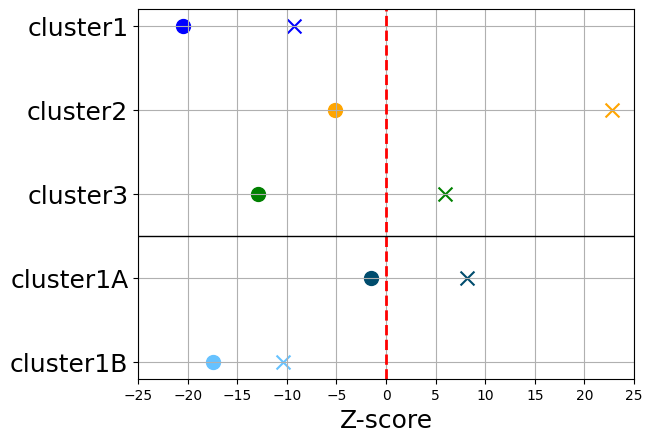

In [ ]:
# Define cluster comparisons, palette, and symbols
clusters_comparisons = [('cluster1', 'cluster1'), ('cluster1', 'rest'), ('cluster2', 'cluster2'), ('cluster2', 'rest'), ('cluster3', 'cluster3'), ('cluster3', 'rest'), ('cluster1A', 'cluster1A'), ('cluster1A', 'rest'), ('cluster1B', 'cluster1B'), ('cluster1B', 'rest')]
cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red'}
symbols = {'within cluster': 'x', 'outside cluster': 'o'}

y_axis_order =['cluster1B', 'cluster1A', 'cluster3','cluster2', 'cluster1']

size = 18
smaller_size = size - 8

df = merged_df.copy()

title = 'Z-score distances to the permuted distributions'

x_vertical_line = 0.0 # if z-score = 0, then it is the same as the expected


# Define the desired order of y-axis labels

# Plotting
for index, row in df.iterrows():
    # Set marker based on ClusterB
    marker = symbols['within cluster'] if 'rest' not in row['clusterB'] else symbols['outside cluster']
    if row['clusterA'] == 'all':
        continue

    # Find the y-axis position for the current cluster
    y_position = y_axis_order.index(row['clusterA'])
    # Plot the data point
    plt.scatter(row['z-score distance'], y_position, color=cluster_palette[row['clusterA']], marker=marker, s=100, alpha=1.0, label='Within cluster' if 'rest' not in row['clusterB'] else 'Outside cluster')

# Set title and labels
plt.axvline(x=x_vertical_line, color='red', linestyle='--', linewidth=2)
#plt.title(title, fontsize=size, pad=15)
plt.xlabel('Z-score', fontsize=size)
plt.yticks(ticks=range(len(y_axis_order)), labels=y_axis_order, fontsize=size)  # Specify the order of the y-ticks
plt.xticks(range(-25, 30, 5), fontsize=smaller_size)

plt.grid(True)

# Add horizontal line between cluster3 and cluster1A
plt.axhline(y=y_axis_order.index('cluster3') - 0.5, color='black', linestyle='-', linewidth=1)

# Add legend
#plt.legend(handles=[plt.Line2D([], [], marker='o', color='black', linestyle='None'),
#                    plt.Line2D([], [], marker='x', color='black', linestyle='None'),
#                    plt.Line2D([], [], color='red', linestyle='--')],
#            labels=['inter-cluster', 'intra-cluster', 'Expected'],
#            title='Type of contacts\n', loc='upper right', bbox_to_anchor=(1.35, 1))

# Show plot
plt.show()

In [ ]:
# Assuming df_permuted and df_observed are already defined

csv_path = results_folder + 'distributions.csv'
read_flag = False

if os.path.exists(csv_path) and read_flag:
    df_distributions = pd.read_csv(csv_path)
else:
    columns = ['clusterA', 'clusterB', 'n_interactions', 'mean_interactions_per_promoter', 'total_promoters_interacting']
    df_distributions = pd.DataFrame(columns=columns)

    for clusterA, clusterB in cluster_combinations:

        # Skip 'all' 'all'
        if clusterA == 'all' and clusterB == 'all':
          continue
        # Obtain dataframe for clusterA, clusterB
        categorical_df = df_permuted[(df_permuted['clusterA'] == clusterA) & (df_permuted['clusterB'] == clusterB)]

        # Convert columns to array
        permuted_interactions = categorical_df['n_interactions'].values
        permuted_meanperprom = categorical_df['mean_interactions_per_promoter'].values
        permuted_totalpromint = categorical_df['total_promoters_interacting'].values

        # Append to df
        df_distributions.loc[len(df_distributions)] = [clusterA, clusterB, permuted_interactions, permuted_meanperprom, permuted_totalpromint]

    df_distributions.to_csv(csv_path, index=False)
df_distributions

,clusterA,clusterB,n_interactions,mean_interactions_per_promoter,total_promoters_interacting
0,cluster1,cluster1,"[60630, 61410, 62882, 61659, 62767, 63841, 640...","[17.30308219178082, 17.52318447710087, 17.9457...","[6969, 6968, 6959, 6959, 6960, 6970, 6967, 697..."
1,cluster1,rest,"[172904, 173161, 173463, 173124, 173221, 17352...","[20.705825998443206, 20.736602598646787, 20.77...","[16630, 16632, 16634, 16627, 16643, 16619, 166..."
2,cluster2,cluster2,"[60174, 58776, 57432, 58664, 58223, 57353, 568...","[17.850489469000298, 17.438362260792168, 17.03...","[6703, 6690, 6689, 6687, 6703, 6708, 6706, 668..."
3,cluster2,rest,"[172417, 171627, 171142, 171916, 171634, 17091...","[20.647506137357045, 20.552901023890787, 20.49...","[16617, 16615, 16634, 16616, 16617, 16624, 166..."
4,cluster3,cluster3,"[11131, 11339, 11401, 11179, 11095, 11131, 112...","[7.543883429345985, 7.684852592341579, 7.72425...","[2849, 2831, 2858, 2865, 2834, 2833, 2854, 282..."
5,cluster3,rest,"[103183, 104536, 104339, 104330, 103349, 10328...","[12.356505598467155, 12.51853182444165, 12.494...","[16181, 16213, 16202, 16246, 16182, 16190, 161..."


In [ ]:
results_folder_1A1B =  drive_folder + "/Part3.Gene_Interactions/" + "results_vPCHiC/" + "1000_permutations/"

df_distributions_1A1B = pd.read_csv(results_folder_1A1B + 'distributions.csv')
# Define the columns containing numerical data
numerical_columns = ['n_interactions']
# Apply conversion to numerical columns only
for column in numerical_columns:
    df_distributions_1A1B[column] = df_distributions_1A1B[column].apply(lambda x: list(map(int, x.strip('[]').split())) if isinstance(x, str) else x)

df_observed_1A1B = pd.read_csv(results_folder_1A1B + 'observed.csv')

merged_distributions_df = pd.concat([df_distributions, df_distributions_1A1B], ignore_index=True)
indexes_to_drop = [10, 11, 12, 13] # repeated cluster1, cluster2 and cluster3
merged_distributions_df = merged_distributions_df.drop(index=indexes_to_drop)

merged_observed_df = pd.concat([df_observed, df_observed_1A1B], ignore_index=True)
merged_distributions_df

,clusterA,clusterB,n_interactions,mean_interactions_per_promoter,total_promoters_interacting
0,cluster1,cluster1,"[60630, 61410, 62882, 61659, 62767, 63841, 640...","[17.30308219178082, 17.52318447710087, 17.9457...","[6969, 6968, 6959, 6959, 6960, 6970, 6967, 697..."
1,cluster1,rest,"[172904, 173161, 173463, 173124, 173221, 17352...","[20.705825998443206, 20.736602598646787, 20.77...","[16630, 16632, 16634, 16627, 16643, 16619, 166..."
2,cluster2,cluster2,"[60174, 58776, 57432, 58664, 58223, 57353, 568...","[17.850489469000298, 17.438362260792168, 17.03...","[6703, 6690, 6689, 6687, 6703, 6708, 6706, 668..."
3,cluster2,rest,"[172417, 171627, 171142, 171916, 171634, 17091...","[20.647506137357045, 20.552901023890787, 20.49...","[16617, 16615, 16634, 16616, 16617, 16624, 166..."
4,cluster3,cluster3,"[11131, 11339, 11401, 11179, 11095, 11131, 112...","[7.543883429345985, 7.684852592341579, 7.72425...","[2849, 2831, 2858, 2865, 2834, 2833, 2854, 282..."
5,cluster3,rest,"[103183, 104536, 104339, 104330, 103349, 10328...","[12.356505598467155, 12.51853182444165, 12.494...","[16181, 16213, 16202, 16246, 16182, 16190, 161..."
6,cluster1A,cluster1A,"[6668, 6159, 6664, 6711, 6412, 7103, 6965, 697...",[5.8058337 5.36498258 5.80487805 5.84327384 5...,[2172 2157 2146 2160 2175 2162 2170 2181 2193 ...
7,cluster1A,rest,"[83844, 81580, 84643, 84756, 82506, 85416, 856...",[10.04059637 9.76947488 10.13627926 10.149811...,[15895 15871 15853 15895 15833 15826 15807 158...
8,cluster1B,cluster1B,"[28585, 28914, 28411, 27898, 29407, 29246, 281...",[12.13542772 12.27510083 12.06155806 11.841256...,[4642 4633 4646 4658 4647 4647 4647 4640 4645 ...
9,cluster1B,rest,"[144494, 144851, 144666, 143277, 146022, 14500...",[17.30363451 17.34638644 17.32423208 17.157894...,[16529 16531 16501 16553 16502 16534 16531 165...


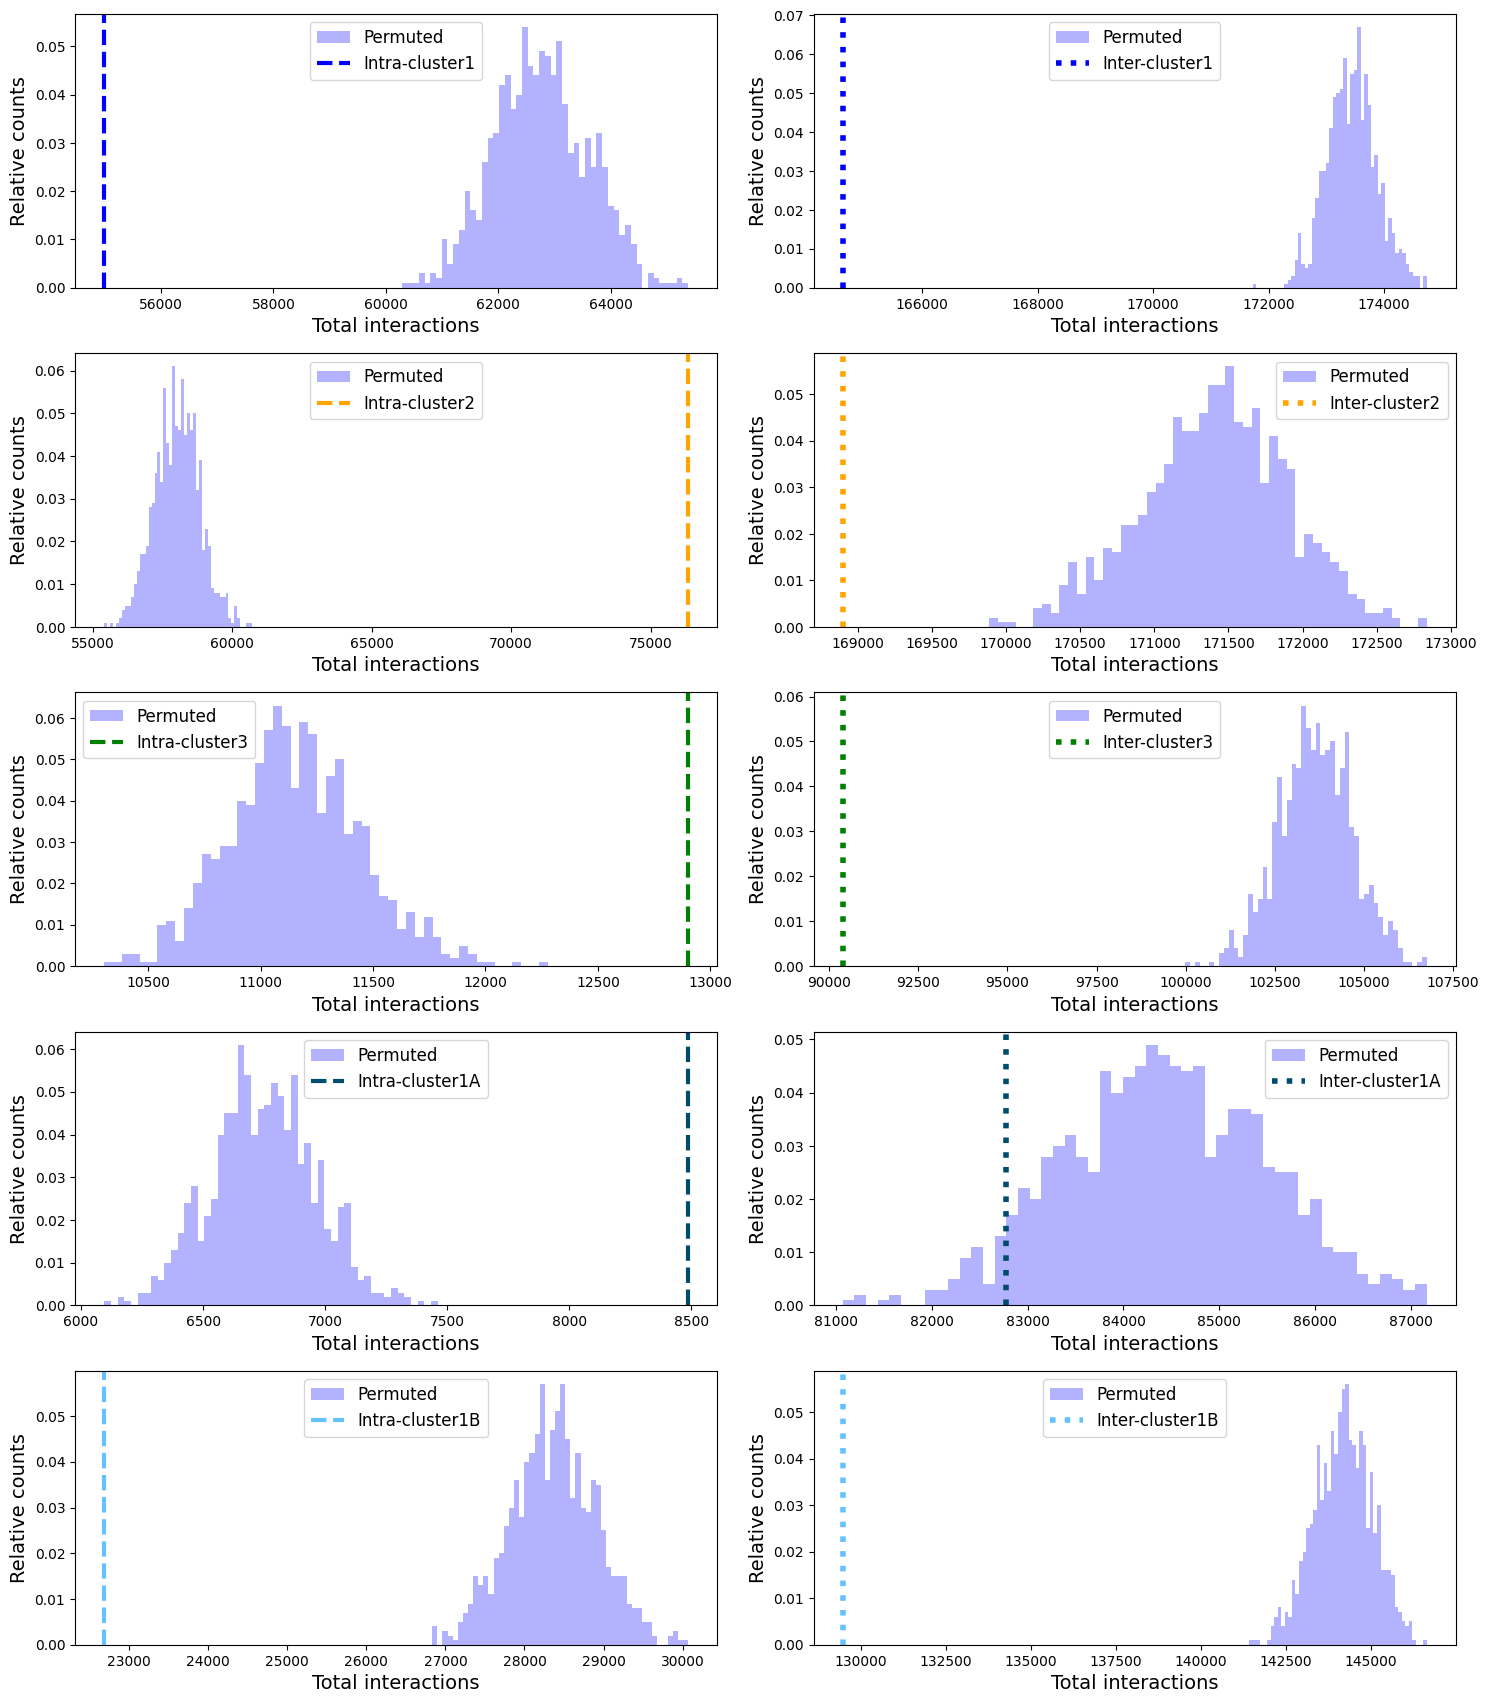

In [ ]:
import matplotlib.pyplot as plt

size = 18
smaller_size = size - 8
legend_size=12
# Define a function to plot distributions
def plot_distributions(column_name):
    plt.figure(figsize=(15, 20))
    for i, row in merged_distributions_df.iterrows():
        clusterA, clusterB = row["clusterA"], row["clusterB"]
        plt.subplot(6, 2, i+1)
        values = row[column_name]
        weights = np.ones_like(values) / len(values)
        plt.hist(values, bins=50, weights=weights, alpha=0.3, label='Permuted', color='blue')
        observed_value = merged_observed_df.loc[(merged_observed_df['clusterA'] == clusterA) & (merged_observed_df['clusterB'] == clusterB), column_name].iloc[0]
        if clusterB == 'rest':
            label = f'Inter-{clusterA}'
            linestyle = ':'
            linewidth=4
        else:
            label = f'Intra-{clusterA}'
            linestyle = 'dashed'
            linewidth=3

        plt.axvline(x=observed_value, color=cluster_palette[clusterA], linestyle=linestyle, linewidth=linewidth, label=label)
        #plt.title(f'{clusterA} vs {clusterB}')
        plt.xticks(fontsize=smaller_size)
        plt.yticks(fontsize=smaller_size)
        if clusterA == 'cluster2' and clusterB == 'rest':
          plt.legend(fontsize=legend_size, loc='upper right')
        elif clusterA == 'cluster1A' and clusterB == 'cluster1A':
          plt.legend(fontsize=legend_size, loc='upper center')
        elif clusterA == 'cluster3' and clusterB == 'cluster3':
          plt.legend(fontsize=legend_size, loc='best')
        else:
          plt.legend(fontsize=legend_size, loc=cluster_legend[clusterA])

        plt.xlabel('Total interactions', fontsize=size-4)  # Set x-axis label
        plt.ylabel('Relative counts', fontsize=size-4)  # Set y-axis label

    plt.tight_layout()
    # Set the size of x-ticks and y-ticks
    #plt.suptitle(f'Distribution of values for {column_name}')
    plt.savefig(png_path)
    plt.show()

png_path = results_folder + 'n_interactions.png'

cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red'}

cluster_legend = {'cluster1': 'upper center', 'cluster1A': 'upper right', 'cluster1B': 'upper center', 'cluster2': 'upper center', 'cluster3': 'upper center', 'all': 'red'}


plot_distributions('n_interactions')


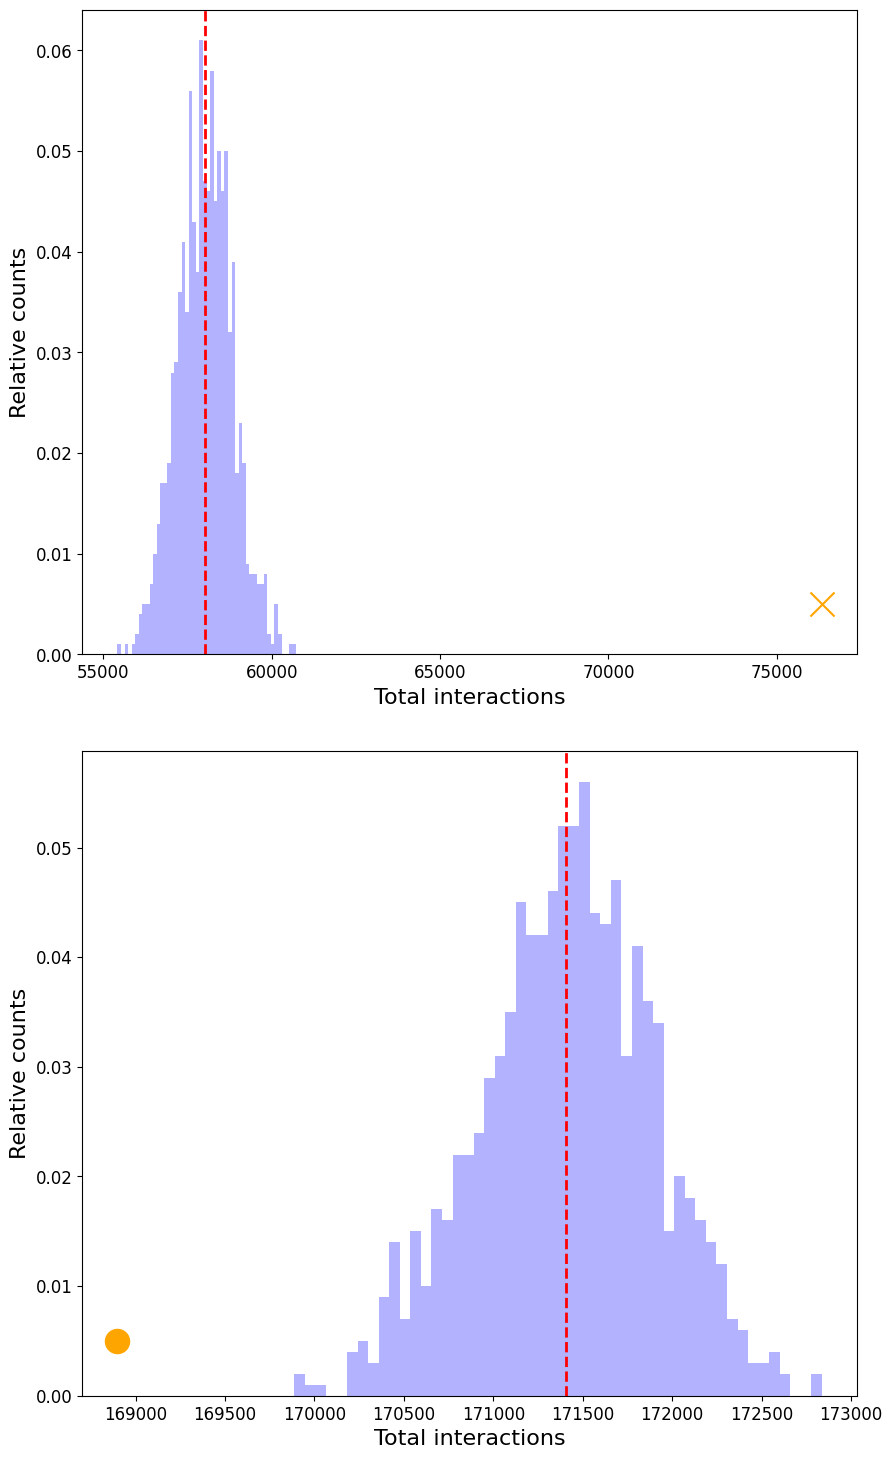

In [ ]:
import matplotlib.pyplot as plt

size = 20
smaller_size = size - 8
legend_size = 18

# Define a function to plot distributions
def plot_distributions(column_name):
    plt.figure(figsize=(10, 18))  # Adjust the figure size as needed

    for i in range(2, 4):  # Plot the third and fourth subplots
        clusterA, clusterB = merged_distributions_df.loc[i, "clusterA"], merged_distributions_df.loc[i, "clusterB"]
        values = merged_distributions_df.loc[i, column_name]
        weights = np.ones_like(values) / len(values)
        plt.subplot(2, 1, i-1)  # Create subplot
        plt.hist(values, bins=50, weights=weights, alpha=0.3, label='Permuted', color='blue')

        observed_value = merged_observed_df.loc[(merged_observed_df['clusterA'] == clusterA) & (merged_observed_df['clusterB'] == clusterB), column_name].iloc[0]

        if clusterB == 'rest':
            label = f'Inter-{clusterA}'
            linestyle = ':'
            linewidth = 8
        else:
            label = f'Intra-{clusterA}'
            linestyle = 'dashed'
            linewidth = 6

        if i == 2:  # For the second subplot
            # Plot big cross at the observed value
            plt.scatter(observed_value, 0.005, s=300, color=cluster_palette[clusterA], marker='x', label=label)
        else:
            # Plot big point at the observed value
            plt.scatter(observed_value, 0.005, s=300, color=cluster_palette[clusterA], marker='o', label=label)

        # Plot vertical line at the mean of the values
        mean_value = np.mean(values)
        plt.axvline(x=mean_value, color='red', linestyle='--', linewidth=2, label='Mean')

        plt.xticks(fontsize=smaller_size)
        plt.yticks(fontsize=smaller_size)

        plt.xlabel('Total interactions', fontsize=size-4)  # Set x-axis label
        plt.ylabel('Relative counts', fontsize=size-4)  # Set y-axis label

    plt.subplots_adjust(hspace=0.15)  # Adjust space between subplots
    plt.show()

png_path = results_folder + 'n_interactions.png'

cluster_palette = {'cluster1': 'blue', 'cluster1A': '#004c6d', 'cluster1B': '#66c2ff', 'cluster2': 'orange', 'cluster3': 'green', 'all': 'red'}

cluster_legend = {'cluster1': 'upper center', 'cluster1A': 'upper right', 'cluster1B': 'upper center', 'cluster2': 'upper center', 'cluster3': 'upper center', 'all': 'red'}

plot_distributions('n_interactions')



In [ ]:
merged_distributions_df

,clusterA,clusterB,n_interactions,mean_interactions_per_promoter,total_promoters_interacting
0,cluster1,cluster1,"[60630, 61410, 62882, 61659, 62767, 63841, 640...","[17.30308219178082, 17.52318447710087, 17.9457...","[6969, 6968, 6959, 6959, 6960, 6970, 6967, 697..."
1,cluster1,rest,"[172904, 173161, 173463, 173124, 173221, 17352...","[20.705825998443206, 20.736602598646787, 20.77...","[16630, 16632, 16634, 16627, 16643, 16619, 166..."
2,cluster2,cluster2,"[60174, 58776, 57432, 58664, 58223, 57353, 568...","[17.850489469000298, 17.438362260792168, 17.03...","[6703, 6690, 6689, 6687, 6703, 6708, 6706, 668..."
3,cluster2,rest,"[172417, 171627, 171142, 171916, 171634, 17091...","[20.647506137357045, 20.552901023890787, 20.49...","[16617, 16615, 16634, 16616, 16617, 16624, 166..."
4,cluster3,cluster3,"[11131, 11339, 11401, 11179, 11095, 11131, 112...","[7.543883429345985, 7.684852592341579, 7.72425...","[2849, 2831, 2858, 2865, 2834, 2833, 2854, 282..."
5,cluster3,rest,"[103183, 104536, 104339, 104330, 103349, 10328...","[12.356505598467155, 12.51853182444165, 12.494...","[16181, 16213, 16202, 16246, 16182, 16190, 161..."
6,cluster1A,cluster1A,"[6668, 6159, 6664, 6711, 6412, 7103, 6965, 697...",[5.8058337 5.36498258 5.80487805 5.84327384 5...,[2172 2157 2146 2160 2175 2162 2170 2181 2193 ...
7,cluster1A,rest,"[83844, 81580, 84643, 84756, 82506, 85416, 856...",[10.04059637 9.76947488 10.13627926 10.149811...,[15895 15871 15853 15895 15833 15826 15807 158...
8,cluster1B,cluster1B,"[28585, 28914, 28411, 27898, 29407, 29246, 281...",[12.13542772 12.27510083 12.06155806 11.841256...,[4642 4633 4646 4658 4647 4647 4647 4640 4645 ...
9,cluster1B,rest,"[144494, 144851, 144666, 143277, 146022, 14500...",[17.30363451 17.34638644 17.32423208 17.157894...,[16529 16531 16501 16553 16502 16534 16531 165...


**Perform scale for Figure 5 B**

In [ ]:
distributions_df = merged_distributions_df[['clusterA', 'clusterB', 'n_interactions']]
distributions_df

,clusterA,clusterB,n_interactions
0,cluster1,cluster1,"[60630, 61410, 62882, 61659, 62767, 63841, 640..."
1,cluster1,rest,"[172904, 173161, 173463, 173124, 173221, 17352..."
2,cluster2,cluster2,"[60174, 58776, 57432, 58664, 58223, 57353, 568..."
3,cluster2,rest,"[172417, 171627, 171142, 171916, 171634, 17091..."
4,cluster3,cluster3,"[11131, 11339, 11401, 11179, 11095, 11131, 112..."
5,cluster3,rest,"[103183, 104536, 104339, 104330, 103349, 10328..."
6,cluster1A,cluster1A,"[6668, 6159, 6664, 6711, 6412, 7103, 6965, 697..."
7,cluster1A,rest,"[83844, 81580, 84643, 84756, 82506, 85416, 856..."
8,cluster1B,cluster1B,"[28585, 28914, 28411, 27898, 29407, 29246, 281..."
9,cluster1B,rest,"[144494, 144851, 144666, 143277, 146022, 14500..."
